# Home Cage Elo Score Calculation

## Importing other Python Libraries/Modules

In [1]:
import re
import os
import sys
import string
from collections import defaultdict
import glob
import warnings
from datetime import datetime
from datetime import timedelta
import ast

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xlrd
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

In [3]:
# setting path
sys.path.append('../../src')

In [4]:
from eloscore import eloscore

In [5]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (18,10)

## Summary

- Experiment
    - Observing fighting behavior between mice in their home cage in different settings. Mice are categorized as winner and loser based on if they initiated the behavior or if they are recieving it. Recording sessions are usually from 30 minutes to a hour with cages of 2 to 6 mice.
- Data
    - Excel spreadsheet of recorded fighting behavior. The relevant columns are those of the "Date" of the recording, the "winner" of the interaction, and the "loser" of the interaction. Each row will be for one interaction between two mice.
    - There is a cage for each sheet of the spreadsheet
    - For each recording session, we will assume that the date will be specified for that first row. We will use this to seperate all the rows into seperate sessions.
- Purpose of this Jupyter Notebook
    - To calculate the Elo Score of each mice after each interaction. The mice start off with an Elo score of 1000. Elo scores are calculated with the formula from here: https://www.omnicalculator.com/sports/elo . Then we will plot the change of elo score across all interactions. With the number of interactions on the X-Axis and the current Elo score on the Y. There will be a line for mice.

## Name of protocol for naming

- This name will be used to name files and title plots. Please change if you are using a different protocol or adding more details
    - **NOTE**: This should be changed based on the name the protocol

In [6]:
protocol_name = "home_cage_observation"

## Getting the file name of the raw data

- Default input folder and keyword to search the files for 
    - **NOTE**: This should not be changed unless there is a consistent change with the file naming convention

In [7]:
input_folder = "./data"

In [8]:
# Accomodates for both capitalization of the file names
raw_data_file_keyword = '*[hH]ome*'

- Asking the user what the path to the recording files are, with the option of using wildcards

In [9]:
raw_data_glob_pattern = input("""Type out the path(address) of the raw behavioral recording excel sheets.
Remember that if you are using a relative path, it will be based off of the location of this Jupyter Notebook.

Globbing can also be used if you want to search with a wild card(Capitalization matters). 
i.e. './data/*Home*' will be able to find './data/Homecage_observations.xlsx'

NOTE: If left blank, the path will automatically be guessed off of the default settings 
""")

Type out the path(address) of the raw behavioral recording excel sheets.
Remember that if you are using a relative path, it will be based off of the location of this Jupyter Notebook.

Globbing can also be used if you want to search with a wild card(Capitalization matters). 
i.e. './data/*Home*' will be able to find './data/Homecage_observations.xlsx'

NOTE: If left blank, the path will automatically be guessed off of the default settings 
./data/pilot_2_home_cage.xlsx


- By default, this will search for files that are in the `./data` folder (in the folder that this notebook is in) that have key word you specified in the file name

In [10]:
# Using the user inputted path/pattern
if raw_data_glob_pattern.strip():
    # Getting a list of all matching files
    raw_data_files_list = glob.glob(raw_data_glob_pattern.strip())
    # Checking if there were any files that matched
    if raw_data_files_list:
        raw_data_file_path = raw_data_files_list[0]
    else:
        raise ValueError("No files were found with the path/pattern of {}. Please rerun the previous cell with the correct path".format(raw_data_glob_pattern))

# Using the default pattern
else:
    # Searching for matching files with recursion
    if glob.glob(os.path.join(input_folder + "**", raw_data_file_keyword)):
        raw_data_glob_pattern = os.path.join(input_folder + "**", raw_data_file_keyword)
        # Getting a list of all matching files
        raw_data_files_list = glob.glob(raw_data_glob_pattern)
    # Searching for matching files only in the specified folder
    elif glob.glob(os.path.join(input_folder, raw_data_file_keyword)):
        raw_data_glob_pattern = glob.glob(os.path.join(input_folder, raw_data_file_keyword))
        # Getting a list of all matching files
        raw_data_files_list = glob.glob(raw_data_glob_pattern)
    else:
        raise ValueError("No files were found in {} that had the keyword {} in it".format(input_folder, raw_data_file_keyword))


- Checking to see if only one file is specified

In [11]:
if len(raw_data_files_list) >= 2:
    raise ValueError("More than one file was found with the path/pattern of {}. Please rerun the previous cell with the correct path".format(raw_data_glob_pattern))
else:
    # Using the first(and only file) as the file path
    raw_data_file_path = raw_data_files_list[0]

In [12]:
raw_data_file_path

'./data/pilot_2_home_cage.xlsx'

## Getting a list of all the sheets

In [13]:
# Getting the sheet names for the excel file
xls = pd.ExcelFile(raw_data_file_path)
raw_data_sheet_names = xls.sheet_names

In [14]:
raw_data_sheet_names

['Legend and Scoring', 'CAGE1', 'CAGE2', 'CAGE3', 'CAGE4', 'CAGE5', 'CAGE6']

- Asking the user what sheets they want to use

In [15]:
inputted_sheet_names_string = input("""Type out the name of the sheets that you want to be processed. 
Each name must be put in quotes and seperated by a comma(,). i.e. "CAGE3", "CAGE4"

The available sheets are: {}

Alternatively, you can use the index of the list of names above. 
Remember, that Python is zero indexed so the first item will be have the 0 index, second the 1 index, and so on. 
i.e. 1, 2

NOTE: If left blank, all sheets will be used
""".format(raw_data_sheet_names))

Type out the name of the sheets that you want to be processed. 
Each name must be put in quotes and seperated by a comma(,). i.e. "CAGE3", "CAGE4"

The available sheets are: ['Legend and Scoring', 'CAGE1', 'CAGE2', 'CAGE3', 'CAGE4', 'CAGE5', 'CAGE6']

Alternatively, you can use the index of the list of names above. 
Remember, that Python is zero indexed so the first item will be have the 0 index, second the 1 index, and so on. 
i.e. 1, 2

NOTE: If left blank, all sheets will be used
'CAGE1', 'CAGE2', 'CAGE3', 'CAGE4', 'CAGE5', 'CAGE6'


In [16]:
# Making a list out of the string of inputted sheet names
if inputted_sheet_names_string:
    inputted_sheet_names_string = "[" + inputted_sheet_names_string + "]"
    # Turning the string into a list
    inputted_sheet_names_list = ast.literal_eval(inputted_sheet_names_string)
# Using all the sheet names if no sheet name is specified
else:
    inputted_sheet_names_list =  raw_data_sheet_names

In [17]:
inputted_sheet_names_list

['CAGE1', 'CAGE2', 'CAGE3', 'CAGE4', 'CAGE5', 'CAGE6']

- Converting all the numbers into the sheet name that the index of the number corresponds to

In [18]:
for index, sheet in enumerate(inputted_sheet_names_list):
    # Checking if the sheet name was a number
    if isinstance(sheet, int) and str(sheet).isdigit():
        inputted_sheet_names_list[index] =  raw_data_sheet_names[sheet]

In [19]:
inputted_sheet_names_list

['CAGE1', 'CAGE2', 'CAGE3', 'CAGE4', 'CAGE5', 'CAGE6']

- Checking to see if all the sheets are in the excel file

In [20]:
if not set(inputted_sheet_names_list).issubset(raw_data_sheet_names):
    # Getting all the sheets that were not in the original spreadsheet
    not_included_sheet_names = set(inputted_sheet_names_list) - set(raw_data_sheet_names)
    raise ValueError("All the listed sheet names are not in {}".format(not_included_sheet_names))

## Finding the row for the header

- Headers are the row in a spreadsheet that has all the column names. Sometimes spreadsheets don't use the first row as the row with the column names. So, the row for the header will be asked or assumed to be the first row

In [21]:
sheet_name_to_everything = defaultdict(dict)
for sheet in inputted_sheet_names_list:
    print("\nCurrent Sheet Name: {}".format(sheet))    
    per_sheet_dataframe = pd.read_excel(raw_data_file_path, sheet_name=sheet, header=0)
    
    # Showing the columns that are chosen with the header being the 0th row
    print("Columns Names: {}".format(per_sheet_dataframe.columns))
    # Show the dataframe that would be created with the header being the 0th row
    print("First few rows of this dataframe:")
    print(pd.read_excel(raw_data_file_path, sheet_name=sheet, header=0).head())
    
    # Allowing the user the choose the row number for the header
    header_row = input("""Type the row number to be used as the header
    (AKA the row with the column name that you want to use.)
    If you want to keep the column names that were displayed, type 0.
    If you want to use a different row, then type the corresponding number. 
    
    The rows displayed in this cell are dataframes created from Pandas. 
    To use the row with the 0 index for column names, type 1. 
    For the row with the 1 index, it will be 2 and so on. i.e. 2
    
    If you are looking at the original spread sheet, remember that Python is zero indexed. 
    So the first row will be 0, second will be 1, and so on. 
    i.e. 1
    
    NOTE: If left blank, the original row that was used will be used.
    """).strip()
    
    if header_row == "":
        header_row = 0
    else:
        header_row = int(header_row)
    
    # Checking if any of the column names are from empty cells
    column_names = "".join([str(col) for col in pd.read_excel(raw_data_file_path, sheet_name=sheet, header=header_row).columns])
    # If a column name came from an empty cell, it would have "Unnamed" in it
    if "Unnamed" in column_names:
        raise ValueError("""Not all the cells in the chosen row are filled in.
                         Please choose a row that has the name of the columns
                         
                         The values in this row are: {}""".format(column_names))
    else:
        sheet_name_to_everything[sheet]["header_row"] = header_row


Current Sheet Name: CAGE1
Columns Names: Index(['Unnamed: 0', 'any details on method ', 'Unnamed: 2', 'Unnamed: 3',
       'Unnamed: 4', 'Unnamed: 5',
       'who gets the point and who loses one (only Fights and Chases get points). The winner gets 1 point and loser -1 ',
       'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10'],
      dtype='object')
First few rows of this dataframe:
  Unnamed: 0                          any details on method   \
0   observer                                           notes   
1    Isabel    9:27-9:57am, C57 lots of grooming and rearing   
2        NaN                                             NaN   
3        NaN                                             NaN   
4        NaN                                             NaN   

               Unnamed: 2           Unnamed: 3 Unnamed: 4 Unnamed: 5  \
0  length of observations                 date     winner      loser   
1                   30min  2022-06-29 00:00:00          3          1   
2   

Type the row number to be used as the header
    (AKA the row with the column name that you want to use.)
    If you want to keep the column names that were displayed, type 0.
    If you want to use a different row, then type the corresponding number. 
    
    The rows displayed in this cell are dataframes created from Pandas. 
    To use the row with the 0 index for column names, type 1. 
    For the row with the 1 index, it will be 2 and so on. i.e. 2
    
    If you are looking at the original spread sheet, remember that Python is zero indexed. 
    So the first row will be 0, second will be 1, and so on. 
    i.e. 1
    
    NOTE: If left blank, the original row that was used will be used.
    1

Current Sheet Name: CAGE4
Columns Names: Index(['Unnamed: 0',
       'any details on method (e.g. right after tube test or isolation ,etc)',
       'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5',
       'who gets the point and who loses one (only Fights and Chases get points). The

Type the row number to be used as the header
    (AKA the row with the column name that you want to use.)
    If you want to keep the column names that were displayed, type 0.
    If you want to use a different row, then type the corresponding number. 
    
    The rows displayed in this cell are dataframes created from Pandas. 
    To use the row with the 0 index for column names, type 1. 
    For the row with the 1 index, it will be 2 and so on. i.e. 2
    
    If you are looking at the original spread sheet, remember that Python is zero indexed. 
    So the first row will be 0, second will be 1, and so on. 
    i.e. 1
    
    NOTE: If left blank, the original row that was used will be used.
    1


In [22]:
sheet_name_to_everything

defaultdict(dict,
            {'CAGE1': {'header_row': 1},
             'CAGE2': {'header_row': 1},
             'CAGE3': {'header_row': 1},
             'CAGE4': {'header_row': 1},
             'CAGE5': {'header_row': 1},
             'CAGE6': {'header_row': 1}})

## Reading in all the spreadsheets

In [23]:
# Going through each sheet and creating a dataframe of it
for key, value in sheet_name_to_everything.items():
    sheet_name_to_everything[key]["original_behavior_recording_dataframe"] = pd.read_excel(raw_data_file_path, sheet_name=key, header=value["header_row"])

In [24]:
sheet_name_to_everything[key]["original_behavior_recording_dataframe"].head()

,observer,notes,length of observations,date,winner,loser,action,1,2,3,4,Initiator,Reciever,FS Count
0,Jocelyn,AM,30 min,2022-06-29,3,1,fs,NaN,NaN,NaN,NaN,1,2,5
1,NaN,NaN,NaN,NaT,4,2,fs,NaN,NaN,NaN,NaN,1,3,2
2,NaN,NaN,NaN,NaT,4,3,fs,NaN,NaN,NaN,NaN,1,4,4
3,NaN,NaN,NaN,NaT,2,1,fs,NaN,NaN,NaN,NaN,2,1,38
4,NaN,NaN,NaN,NaT,4,3,as,NaN,NaN,NaN,NaN,2,3,8


In [25]:
sheet_name_to_everything[key]["original_behavior_recording_dataframe"].tail()

,observer,notes,length of observations,date,winner,loser,action,1,2,3,4,Initiator,Reciever,FS Count
587,NaN,NaN,NaN,NaT,1,4,f,1.0,NaN,NaN,-1.0,NaN,NaN,NaN
588,NaN,NaN,NaN,NaT,1,4,f,1.0,NaN,NaN,-1.0,NaN,NaN,NaN
589,NaN,NaN,NaN,NaT,1,2,c,1.0,1.0,NaN,NaN,NaN,NaN,NaN
590,NaN,NaN,NaN,NaT,1,2,c,1.0,1.0,NaN,NaN,NaN,NaN,NaN
591,NaN,NaN,NaN,NaT,1,4,f,1.0,-1.0,NaN,NaN,NaN,NaN,NaN


## Standarizing the Columns

- Making all the column names lower case and removing any extra spaces in the beginning and at the end

In [26]:
for key, value in sheet_name_to_everything.items():
    # Creating a dictionary that maps the original column name to the standarized one
    column_name_to_standarized = defaultdict(dict)
    for col in sheet_name_to_everything[key]["original_behavior_recording_dataframe"]:
        # Making the column name lower case and removing the spaces
        column_name_to_standarized[col] = str(col).lower().strip()
    sheet_name_to_everything[key]["column_name_to_standarized"] = column_name_to_standarized

In [27]:
sheet_name_to_everything[key]["column_name_to_standarized"]

defaultdict(dict,
            {'observer': 'observer',
             'notes ': 'notes',
             'length of observations': 'length of observations',
             'date': 'date',
             'winner': 'winner',
             'loser': 'loser',
             'action': 'action',
             1: '1',
             2: '2',
             3: '3',
             4: '4',
             'Initiator ': 'initiator',
             'Reciever': 'reciever',
             'FS Count': 'fs count'})

In [28]:
# Renaming all the columns to the lower case and space removed version
for key, value in sheet_name_to_everything.items():
    sheet_name_to_everything[key]["processed_behavior_recording_dataframe"] = sheet_name_to_everything[key]["original_behavior_recording_dataframe"].rename(columns=sheet_name_to_everything[key]["column_name_to_standarized"])

In [29]:
sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].head()

,observer,notes,length of observations,date,winner,loser,action,1,2,3,4,initiator,reciever,fs count
0,Jocelyn,AM,30 min,2022-06-29,3,1,fs,NaN,NaN,NaN,NaN,1,2,5
1,NaN,NaN,NaN,NaT,4,2,fs,NaN,NaN,NaN,NaN,1,3,2
2,NaN,NaN,NaN,NaT,4,3,fs,NaN,NaN,NaN,NaN,1,4,4
3,NaN,NaN,NaN,NaT,2,1,fs,NaN,NaN,NaN,NaN,2,1,38
4,NaN,NaN,NaN,NaT,4,3,as,NaN,NaN,NaN,NaN,2,3,8


## Getting the cage number

- The cage number is sometimes not consistent throughout a spreadsheet for the same cage. So we will try to standarize it into one value.
    - **NOTE**: This assumes cage numbers are actual numbers. And not entirely consisting of letters. If that isn't the case, then you must edit this cell for your needs.

In [30]:
for key, value in sheet_name_to_everything.items():
    # Asking the user which column has the cage number
    sheet_name_to_everything[key]["cage_column"] = input("""Type the name of the column of the subject that has won the interaction.
    i.e. "cage"

    The available columns are: {}

    Note: If left blank, the column with "cage" will be used as the column. If there is none, then the sheet name will be used.
    """.format(sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].columns))
    
    # Getting the column that has "cage" in its name if no column is specified
    if not sheet_name_to_everything[key]["cage_column"]:
        if [col for col in sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].columns if "cage" in col.lower()]:
            sheet_name_to_everything[key]["cage_column"] = [col for col in sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].columns if "cage" in col.lower()][0]
        else:
            sheet_name_to_everything[key]["cage_column"] = "cage"
            sheet_name_to_everything[key]["processed_behavior_recording_dataframe"]["cage"] = key
            
    
    # Creating a dictionary of original cage name to standarized cage namec
    sheet_name_to_everything[key]["cage_string_to_number"] = defaultdict(dict)
    # Getting all the unique cage names
    unique_cage_numbers = sheet_name_to_everything[key]["processed_behavior_recording_dataframe"][sheet_name_to_everything[key]["cage_column"]].unique()
    for cage_string in unique_cage_numbers:
        # Getting the number from the cage name
        sheet_name_to_everything[key]["cage_string_to_number"][cage_string] = re.findall(r'\d+', str(cage_string))[0]
        print(sheet_name_to_everything[key]["cage_string_to_number"])
    # Making a new column for the processed cage number
    sheet_name_to_everything[key]["processed_behavior_recording_dataframe"]["processed_cage_number"] = sheet_name_to_everything[key]["processed_behavior_recording_dataframe"][sheet_name_to_everything[key]["cage_column"]].map(sheet_name_to_everything[key]["cage_string_to_number"])
    

Type the name of the column of the subject that has won the interaction.
    i.e. "cage"

    The available columns are: Index(['observer', 'notes', 'length of observations', 'date', 'winner',
       'loser', 'action', '1', '2', '3', '4'],
      dtype='object')

    Note: If left blank, the column with "cage" will be used as the column. If there is none, then the sheet name will be used.
    
defaultdict(<class 'dict'>, {'CAGE1': '1'})
Type the name of the column of the subject that has won the interaction.
    i.e. "cage"

    The available columns are: Index(['observer', 'notes', 'length of observations', 'date', 'winner',
       'loser', 'action', '1', '2', '3', '4'],
      dtype='object')

    Note: If left blank, the column with "cage" will be used as the column. If there is none, then the sheet name will be used.
    
defaultdict(<class 'dict'>, {'CAGE2': '2'})
Type the name of the column of the subject that has won the interaction.
    i.e. "cage"

    The available columns are:

In [31]:
sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].head()

,observer,notes,length of observations,date,winner,loser,action,1,2,3,4,initiator,reciever,fs count,cage,processed_cage_number
0,Jocelyn,AM,30 min,2022-06-29,3,1,fs,NaN,NaN,NaN,NaN,1,2,5,CAGE6,6
1,NaN,NaN,NaN,NaT,4,2,fs,NaN,NaN,NaN,NaN,1,3,2,CAGE6,6
2,NaN,NaN,NaN,NaT,4,3,fs,NaN,NaN,NaN,NaN,1,4,4,CAGE6,6
3,NaN,NaN,NaN,NaT,2,1,fs,NaN,NaN,NaN,NaN,2,1,38,CAGE6,6
4,NaN,NaN,NaN,NaT,4,3,as,NaN,NaN,NaN,NaN,2,3,8,CAGE6,6


In [32]:
sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].tail()

,observer,notes,length of observations,date,winner,loser,action,1,2,3,4,initiator,reciever,fs count,cage,processed_cage_number
587,NaN,NaN,NaN,NaT,1,4,f,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,CAGE6,6
588,NaN,NaN,NaN,NaT,1,4,f,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,CAGE6,6
589,NaN,NaN,NaN,NaT,1,2,c,1.0,1.0,NaN,NaN,NaN,NaN,NaN,CAGE6,6
590,NaN,NaN,NaN,NaT,1,2,c,1.0,1.0,NaN,NaN,NaN,NaN,NaN,CAGE6,6
591,NaN,NaN,NaN,NaT,1,4,f,1.0,-1.0,NaN,NaN,NaN,NaN,NaN,CAGE6,6


## Adding the session number

- We are adding the session number to all the trials. The session number is counting the number of recording sessions that have happened up until that trial. Usually, each session in the spreadsheet is divided up by a session's first row having the date filled in. So we will label a new session when a date is filled in.

In [33]:
for key, value in sheet_name_to_everything.items():
    # Allowing the user to choose the column that indicates a new session
    session_divider_column = input("""Type the name of the column to be used to divide the rows into sessions. 
    Pick a column that has a value in the cell only with the first row of each session.
    This is usually the "date" column.

    If left blank, the session number will not be added to the spreadsheets and plots will not be divided into sessions.

    The available columns are: {}

    NOTE: If left blank, the column with "date" in the name will be used as the column
    """.format(sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].columns))
    # Making the column name lowercase and removing any punctuation
    sheet_name_to_everything[key]["session_divider_column"] = session_divider_column.lower().strip('"').strip("'").strip()

    # Looks for columns with "date" in them if none of inputted
    if not sheet_name_to_everything[key]["session_divider_column"]:
        sheet_name_to_everything[key]["session_divider_column"] = [col for col in sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].columns if "date" in col.lower()][0]

    # Checks if that column is in the dataframe
    if sheet_name_to_everything[key]["session_divider_column"] not in sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].columns:
        raise ValueError("{} is not a column in {}".format(sheet_name_to_everything[key]["session_divider_column"], sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].columns)) 

Type the name of the column to be used to divide the rows into sessions. 
    Pick a column that has a value in the cell only with the first row of each session.
    This is usually the "date" column.

    If left blank, the session number will not be added to the spreadsheets and plots will not be divided into sessions.

    The available columns are: Index(['observer', 'notes', 'length of observations', 'date', 'winner',
       'loser', 'action', '1', '2', '3', '4', 'cage', 'processed_cage_number'],
      dtype='object')

    NOTE: If left blank, the column with "date" in the name will be used as the column
    
Type the name of the column to be used to divide the rows into sessions. 
    Pick a column that has a value in the cell only with the first row of each session.
    This is usually the "date" column.

    If left blank, the session number will not be added to the spreadsheets and plots will not be divided into sessions.

    The available columns are: Index(['observer', 'not

In [34]:
for key, value in sheet_name_to_everything.items():
    # Getting the indexes of all the rows that have the date or the column that divides the sessions up
    sheet_name_to_everything[key]["session_indexes"] = sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].dropna(axis=0, subset=sheet_name_to_everything[key]["session_divider_column"]).index
    # Adding the session number to each row
    sheet_name_to_everything[key]["processed_behavior_recording_dataframe"] = eloscore.add_session_number_column(sheet_name_to_everything[key]["processed_behavior_recording_dataframe"], sheet_name_to_everything[key]["session_indexes"], session_number_column='session_number')
    
    # Filling in the NaNs for the session number
    sheet_name_to_everything[key]["processed_behavior_recording_dataframe"]["session_number"] = sheet_name_to_everything[key]["processed_behavior_recording_dataframe"]["session_number"].fillna(method='ffill')

## Dropping All Rows without a Winner

- Because we will be filling all empty cells with the previous value, we must remove all rows that don't have any data. This is usually cells that don't have any winners or losers filled in the row.

In [35]:
for key, value in sheet_name_to_everything.items():
    # Asking users to specify which column is the one with the winner's information
    sheet_name_to_everything[key]["winner_column"] = input("""Type the name of the column of the subject that has won the interaction.
    i.e. "winner"
    
    The available columns are: {}

    Note: If left blank, the column with "winner" in the name will be used as the column
    """.format(sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].columns))
        
    # Looks for columns with "winner" in them if none of inputted
    if not sheet_name_to_everything[key]["winner_column"]:
        sheet_name_to_everything[key]["winner_column"] = [col for col in sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].columns if "winner" in col.lower()][0]

        
    # Asking users to specify which column is the one with the winner's information
    sheet_name_to_everything[key]["loser_column"] = input("""Type the name of the column of the subject that has won the interaction.
    i.e. "loser"

    The available columns are: {}

    Note: If left blank, the column with "loser" in the name will be used as the column
    """.format(sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].columns))

    # Looks for columns with "loser" in them if none of inputted
    if not sheet_name_to_everything[key]["loser_column"]:
        sheet_name_to_everything[key]["loser_column"] = [col for col in sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].columns if "loser" in col.lower()][0]

    # Dropping all rows that don't have any values in the winner column
    sheet_name_to_everything[key]["processed_behavior_recording_dataframe"] = sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].dropna(subset=sheet_name_to_everything[key]["winner_column"])
    sheet_name_to_everything[key]["processed_behavior_recording_dataframe"][sheet_name_to_everything[key]["winner_column"]] = sheet_name_to_everything[key]["processed_behavior_recording_dataframe"][sheet_name_to_everything[key]["winner_column"]].astype(int)
    sheet_name_to_everything[key]["processed_behavior_recording_dataframe"][sheet_name_to_everything[key]["loser_column"]] = sheet_name_to_everything[key]["processed_behavior_recording_dataframe"][sheet_name_to_everything[key]["loser_column"]].astype(int)

Type the name of the column of the subject that has won the interaction.
    i.e. "winner"
    
    The available columns are: Index(['observer', 'notes', 'length of observations', 'date', 'winner',
       'loser', 'action', '1', '2', '3', '4', 'cage', 'processed_cage_number',
       'session_number'],
      dtype='object')

    Note: If left blank, the column with "winner" in the name will be used as the column
    
Type the name of the column of the subject that has won the interaction.
    i.e. "loser"

    The available columns are: Index(['observer', 'notes', 'length of observations', 'date', 'winner',
       'loser', 'action', '1', '2', '3', '4', 'cage', 'processed_cage_number',
       'session_number'],
      dtype='object')

    Note: If left blank, the column with "loser" in the name will be used as the column
    
Type the name of the column of the subject that has won the interaction.
    i.e. "winner"
    
    The available columns are: Index(['observer', 'notes', 'length o

In [36]:

sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].head()

,observer,notes,length of observations,date,winner,loser,action,1,2,3,4,initiator,reciever,fs count,cage,processed_cage_number,session_number
0,Jocelyn,AM,30 min,2022-06-29,3,1,fs,NaN,NaN,NaN,NaN,1,2,5,CAGE6,6,1.0
1,NaN,NaN,NaN,NaT,4,2,fs,NaN,NaN,NaN,NaN,1,3,2,CAGE6,6,1.0
2,NaN,NaN,NaN,NaT,4,3,fs,NaN,NaN,NaN,NaN,1,4,4,CAGE6,6,1.0
3,NaN,NaN,NaN,NaT,2,1,fs,NaN,NaN,NaN,NaN,2,1,38,CAGE6,6,1.0
4,NaN,NaN,NaN,NaT,4,3,as,NaN,NaN,NaN,NaN,2,3,8,CAGE6,6,1.0


In [37]:
sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].tail()

,observer,notes,length of observations,date,winner,loser,action,1,2,3,4,initiator,reciever,fs count,cage,processed_cage_number,session_number
587,NaN,NaN,NaN,NaT,1,4,f,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,CAGE6,6,16.0
588,NaN,NaN,NaN,NaT,1,4,f,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,CAGE6,6,16.0
589,NaN,NaN,NaN,NaT,1,2,c,1.0,1.0,NaN,NaN,NaN,NaN,NaN,CAGE6,6,16.0
590,NaN,NaN,NaN,NaT,1,2,c,1.0,1.0,NaN,NaN,NaN,NaN,NaN,CAGE6,6,16.0
591,NaN,NaN,NaN,NaT,1,4,f,1.0,-1.0,NaN,NaN,NaN,NaN,NaN,CAGE6,6,16.0


## Adding the match number

In [38]:
for key, value in sheet_name_to_everything.items():
    sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].insert(0, 'all_trial_number', range(0, 0 + len(sheet_name_to_everything[key]["processed_behavior_recording_dataframe"])))

## Picking what the action column is

- Specific for home cage observations. This protocol records the type of action that occured between an initiator and reciever. Only certain actions(usually fighting and chasing) are counted towards points for the ELO score. So we will remove all other rows that contain different actions

In [39]:
for key, value in sheet_name_to_everything.items():
    # Asking the user which column is the column that has the actions recorded
    sheet_name_to_everything[key]["action_column"] = input("""Type the name of the column that has the action recorded.

    The available columns are: {}

    If left blank, the column name will assumed to be "action"
    """.format(sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].columns))

    if sheet_name_to_everything[key]["action_column"]:
        sheet_name_to_everything[key]["action_column"] = sheet_name_to_everything[key]["action_column"].lower().strip()
    else: 
        sheet_name_to_everything[key]["action_column"] = "action"
        
    sheet_name_to_everything[key]["processed_behavior_recording_dataframe"][sheet_name_to_everything[key]["action_column"]] = sheet_name_to_everything[key]["processed_behavior_recording_dataframe"][sheet_name_to_everything[key]["action_column"]].apply(lambda x: x.strip())
    
    

Type the name of the column that has the action recorded.

    The available columns are: Index(['all_trial_number', 'observer', 'notes', 'length of observations',
       'date', 'winner', 'loser', 'action', '1', '2', '3', '4', 'cage',
       'processed_cage_number', 'session_number'],
      dtype='object')

    If left blank, the column name will assumed to be "action"
    
Type the name of the column that has the action recorded.

    The available columns are: Index(['all_trial_number', 'observer', 'notes', 'length of observations',
       'date', 'winner', 'loser', 'action', '1', '2', '3', '4', 'cage',
       'processed_cage_number', 'session_number'],
      dtype='object')

    If left blank, the column name will assumed to be "action"
    
Type the name of the column that has the action recorded.

    The available columns are: Index(['all_trial_number', 'observer', 'notes', 'length of observations',
       'date', 'winner', 'loser', 'action', '1', '2', '3', '4', 'cage',
       '

In [40]:
sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].head()

,all_trial_number,observer,notes,length of observations,date,winner,loser,action,1,2,3,4,initiator,reciever,fs count,cage,processed_cage_number,session_number
0,0,Jocelyn,AM,30 min,2022-06-29,3,1,fs,NaN,NaN,NaN,NaN,1,2,5,CAGE6,6,1.0
1,1,NaN,NaN,NaN,NaT,4,2,fs,NaN,NaN,NaN,NaN,1,3,2,CAGE6,6,1.0
2,2,NaN,NaN,NaN,NaT,4,3,fs,NaN,NaN,NaN,NaN,1,4,4,CAGE6,6,1.0
3,3,NaN,NaN,NaN,NaT,2,1,fs,NaN,NaN,NaN,NaN,2,1,38,CAGE6,6,1.0
4,4,NaN,NaN,NaN,NaT,4,3,as,NaN,NaN,NaN,NaN,2,3,8,CAGE6,6,1.0


In [41]:
sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].tail()

,all_trial_number,observer,notes,length of observations,date,winner,loser,action,1,2,3,4,initiator,reciever,fs count,cage,processed_cage_number,session_number
587,587,NaN,NaN,NaN,NaT,1,4,f,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,CAGE6,6,16.0
588,588,NaN,NaN,NaN,NaT,1,4,f,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,CAGE6,6,16.0
589,589,NaN,NaN,NaN,NaT,1,2,c,1.0,1.0,NaN,NaN,NaN,NaN,NaN,CAGE6,6,16.0
590,590,NaN,NaN,NaN,NaT,1,2,c,1.0,1.0,NaN,NaN,NaN,NaN,NaN,CAGE6,6,16.0
591,591,NaN,NaN,NaN,NaT,1,4,f,1.0,-1.0,NaN,NaN,NaN,NaN,NaN,CAGE6,6,16.0


## Calculating ELO Score

- Example calculation

In [42]:
eloscore.calculate_elo_score(subject_elo_score=1000, agent_elo_score=2000)

1019.9

In [43]:
eloscore.update_elo_score(winner_id="A", loser_id="B")

defaultdict(<function eloscore.eloscore.update_elo_score.<locals>.<lambda>()>,
            {'A': 1010.0, 'B': 990.0})

## Get the Elo score for all the events

- Going through each row or interaction and calculating the new ELO score for the winner and loser. This will create a new dataframe based off of the processed behavioral recording dataframe

In [44]:
for key, value in sheet_name_to_everything.items():
    # Keeping all rows that have the inputted action
    sheet_name_to_everything[key]["fight_and_chase_dataframe"] = sheet_name_to_everything[key]["processed_behavior_recording_dataframe"][sheet_name_to_everything[key]["processed_behavior_recording_dataframe"][sheet_name_to_everything[key]["action_column"]].isin(["f", "c"])]


In [45]:
sheet_name_to_everything[key]["fight_and_chase_dataframe"].head()

,all_trial_number,observer,notes,length of observations,date,winner,loser,action,1,2,3,4,initiator,reciever,fs count,cage,processed_cage_number,session_number
13,13,NaN,NaN,NaN,NaT,4,2,f,NaN,-1.0,NaN,1.0,Initiator,Reciever,AS count,CAGE6,6,1.0
14,14,NaN,NaN,NaN,NaT,2,4,f,NaN,1.0,NaN,-1.0,1,2,2,CAGE6,6,1.0
16,16,NaN,NaN,NaN,NaT,2,1,f,-1.0,1.0,NaN,NaN,1,4,3,CAGE6,6,1.0
17,17,NaN,NaN,NaN,NaT,2,1,c,-1.0,1.0,NaN,NaN,2,1,12,CAGE6,6,1.0
19,19,NaN,NaN,NaN,NaT,2,1,f,-1.0,1.0,NaN,NaN,2,4,4,CAGE6,6,1.0


In [46]:
for key, value in sheet_name_to_everything.items():
    # Asking the user which columns to carry over to the ELO Score calculation dataframe
    sheet_name_to_everything[key]["columns_to_keep_string"] = input("""Type all the columns that will be copied from the original dataframe to the ELO Score calculated dataframe. 

    All the available actions: {}
    Each column must be put in quotes and seperated by a comma(,). i.e. 'length of observations', 'date', 'cage #'

    NOTE: If left blank, all the columns will be kept
    """.format(sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].columns))

    
    # Making a list out of the string of inputted sheet names
    if sheet_name_to_everything[key]["columns_to_keep_string"]:
        sheet_name_to_everything[key]["columns_to_keep_string"] = "[" + sheet_name_to_everything[key]["columns_to_keep_string"] + "]"
        sheet_name_to_everything[key]["columns_to_keep_list"] = ast.literal_eval(sheet_name_to_everything[key]["columns_to_keep_string"])
    # Using all the sheet names if no sheet name is specified
    else:
        sheet_name_to_everything[key]["columns_to_keep_list"] =  sorted(list(set(sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].columns) - set([sheet_name_to_everything[key]["winner_column"]]) - set([sheet_name_to_everything[key]["loser_column"]])))
        
    

    # Calculating the Elo Score    
    sheet_name_to_everything[key]["index_to_elo_score_and_meta_data"] = eloscore.iterate_elo_score_calculation_for_dataframe(dataframe=sheet_name_to_everything[key]["fight_and_chase_dataframe"], \
                                                                                                                   winner_column=sheet_name_to_everything[key]["winner_column"], loser_column=sheet_name_to_everything[key]["loser_column"], \
                                                                                                                             additional_columns=sheet_name_to_everything[key]["columns_to_keep_list"])
    # Making a dataframe from the dictionary 
    sheet_name_to_everything[key]["elo_score_dataframe"] = pd.DataFrame.from_dict(sheet_name_to_everything[key]["index_to_elo_score_and_meta_data"], orient="index")


Type all the columns that will be copied from the original dataframe to the ELO Score calculated dataframe. 

    All the available actions: Index(['all_trial_number', 'observer', 'notes', 'length of observations',
       'date', 'winner', 'loser', 'action', '1', '2', '3', '4', 'cage',
       'processed_cage_number', 'session_number'],
      dtype='object')
    Each column must be put in quotes and seperated by a comma(,). i.e. 'length of observations', 'date', 'cage #'

    NOTE: If left blank, all the columns will be kept
    
Type all the columns that will be copied from the original dataframe to the ELO Score calculated dataframe. 

    All the available actions: Index(['all_trial_number', 'observer', 'notes', 'length of observations',
       'date', 'winner', 'loser', 'action', '1', '2', '3', '4', 'cage',
       'processed_cage_number', 'session_number'],
      dtype='object')
    Each column must be put in quotes and seperated by a comma(,). i.e. 'length of observations', 'date',

In [47]:
sheet_name_to_everything[key]["elo_score_dataframe"].head()

,total_match_number,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,subject_ranking,agent_ranking,1,2,...,cage,date,fs count,initiator,length of observations,notes,observer,processed_cage_number,reciever,session_number
0,1,4,2,1000.0,1010.0,1,1,2,NaN,-1.0,...,CAGE6,NaT,AS count,Initiator,NaN,NaN,NaN,6,Reciever,1.0
1,1,2,4,1000.0,990.0,0,2,1,NaN,-1.0,...,CAGE6,NaT,AS count,Initiator,NaN,NaN,NaN,6,Reciever,1.0
2,2,2,4,990.0,1000.6,1,1,2,NaN,1.0,...,CAGE6,NaT,2,1,NaN,NaN,NaN,6,2,1.0
3,2,4,2,1010.0,999.4,0,2,1,NaN,1.0,...,CAGE6,NaT,2,1,NaN,NaN,NaN,6,2,1.0
4,3,2,1,1000.6,1010.6,1,1,3,-1.0,1.0,...,CAGE6,NaT,3,1,NaN,NaN,NaN,6,4,1.0


In [48]:
sheet_name_to_everything[key]["elo_score_dataframe"].tail()

,total_match_number,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,subject_ranking,agent_ranking,1,2,...,cage,date,fs count,initiator,length of observations,notes,observer,processed_cage_number,reciever,session_number
531,266,2,1,780.7,780.2,0,3,1,1.0,1.0,...,CAGE6,NaT,NaN,NaN,NaN,NaN,NaN,6,NaN,16.0
532,267,1,2,1422.3,1422.8,1,1,3,1.0,1.0,...,CAGE6,NaT,NaN,NaN,NaN,NaN,NaN,6,NaN,16.0
533,267,2,1,780.2,779.7,0,3,1,1.0,1.0,...,CAGE6,NaT,NaN,NaN,NaN,NaN,NaN,6,NaN,16.0
534,268,1,4,1422.8,1425.3,1,1,2,1.0,-1.0,...,CAGE6,NaT,NaN,NaN,NaN,NaN,NaN,6,NaN,16.0
535,268,4,1,1082.9,1080.4,0,2,1,1.0,-1.0,...,CAGE6,NaT,NaN,NaN,NaN,NaN,NaN,6,NaN,16.0


In [49]:
sheet_name_to_everything[key]["elo_score_dataframe"].groupby("subject_id").count()

,total_match_number,agent_id,original_elo_score,updated_elo_score,win_draw_loss,subject_ranking,agent_ranking,1,2,3,...,cage,date,fs count,initiator,length of observations,notes,observer,processed_cage_number,reciever,session_number
subject_id,,,,,,,,,,,,,,,,,,,,,
1,167,167,167,167,167,167,167,167,58,49,...,167,9,4,4,8,11,9,167,4,167
2,112,112,112,112,112,112,112,57,112,9,...,112,5,7,7,5,7,5,112,7,112
3,105,105,105,105,105,105,105,50,9,104,...,105,2,1,1,1,2,2,105,1,105
4,152,152,152,152,152,152,152,60,47,46,...,152,6,2,2,4,8,6,152,2,152


# Adding the Ranking of each subject and agent

In [98]:
for key, value in sheet_name_to_everything.items():
    trial_number_to_winner_rank = defaultdict(dict)
    trial_number_to_loser_rank = defaultdict(dict)

    processed_behavior_recording_dataframe = sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].copy()
    for index, row in processed_behavior_recording_dataframe.iterrows():
        trial_number = row["all_trial_number"]

        winner_id = row["winner"]
        loser_id = row["loser"]
        elo_score_dataframe = sheet_name_to_everything[key]["elo_score_dataframe"].copy()
        trial_mask = elo_score_dataframe["all_trial_number"] == trial_number
        print("trial number: ", trial_number)
        # When there is a corresponding match in the ELO score df
        if trial_mask.any():
            print("Trial Exists!")
            trial_number_to_winner_rank[trial_number] = elo_score_dataframe[(trial_mask) & (elo_score_dataframe["win_draw_loss"] == 1)].iloc[0]["subject_ranking"]
            trial_number_to_loser_rank[trial_number] = elo_score_dataframe[(trial_mask) & (elo_score_dataframe["win_draw_loss"] == 0)].iloc[0]["subject_ranking"]
        # When there isn't a corresponding trial in the ELO score df
        # But there is a previous trial with that subject
        # So use the ranking 
        elif ((elo_score_dataframe["all_trial_number"] <= trial_number) & (elo_score_dataframe["subject_id"] == winner_id)).any():
            print("It existed before!!")
            print("original trial number: ", trial_number)
#             elo_score_dataframe[(trial_mask) & (elo_score_dataframe["win_draw_loss"] == 1)].iloc[0]["subject_id"]
#             elo_score_dataframe[(trial_mask) & (elo_score_dataframe["win_draw_loss"] == 0)].iloc[0]["subject_id"]
            
            most_recent_trial_number = elo_score_dataframe[(elo_score_dataframe["all_trial_number"] <= trial_number) & (elo_score_dataframe["subject_id"] == winner_id)]["all_trial_number"].max()
            print("most recent trial number: ", most_recent_trial_number)
            trial_mask = elo_score_dataframe["all_trial_number"] == most_recent_trial_number
            trial_number_to_winner_rank[trial_number] = elo_score_dataframe[(trial_mask) & (elo_score_dataframe["win_draw_loss"] == 1)].iloc[0]["subject_ranking"]
            trial_number_to_loser_rank[trial_number] = elo_score_dataframe[(trial_mask) & (elo_score_dataframe["win_draw_loss"] == 0)].iloc[0]["subject_ranking"]
        # When there is no previous trials
        else:
            print("it does not exist!")
            trial_number_to_winner_rank[trial_number] = 0
            trial_number_to_loser_rank[trial_number] = 0
    processed_behavior_recording_dataframe["winner_ranking"] = processed_behavior_recording_dataframe.apply(lambda row: trial_number_to_winner_rank[row["all_trial_number"]], axis=1)
    processed_behavior_recording_dataframe["loser_ranking"] = processed_behavior_recording_dataframe.apply(lambda row: trial_number_to_loser_rank[row["all_trial_number"]], axis=1)
    sheet_name_to_everything[key]["processed_behavior_recording_dataframe"] = processed_behavior_recording_dataframe
#     break

trial number:  0
it does not exist!
trial number:  1
it does not exist!
trial number:  2
it does not exist!
trial number:  3
it does not exist!
trial number:  4
it does not exist!
trial number:  5
it does not exist!
trial number:  6
it does not exist!
trial number:  7
it does not exist!
trial number:  8
it does not exist!
trial number:  9
it does not exist!
trial number:  10
it does not exist!
trial number:  11
it does not exist!
trial number:  12
it does not exist!
trial number:  13
it does not exist!
trial number:  14
it does not exist!
trial number:  15
it does not exist!
trial number:  16
it does not exist!
trial number:  17
it does not exist!
trial number:  18
it does not exist!
trial number:  19
it does not exist!
trial number:  20
it does not exist!
trial number:  21
it does not exist!
trial number:  22
it does not exist!
trial number:  23
it does not exist!
trial number:  24
it does not exist!
trial number:  25
it does not exist!
trial number:  26
it does not exist!
trial numbe

trial number:  93
It existed before!!
original trial number:  93
most recent trial number:  86
trial number:  94
It existed before!!
original trial number:  94
most recent trial number:  83
trial number:  95
It existed before!!
original trial number:  95
most recent trial number:  86
trial number:  96
It existed before!!
original trial number:  96
most recent trial number:  86
trial number:  97
It existed before!!
original trial number:  97
most recent trial number:  83
trial number:  98
It existed before!!
original trial number:  98
most recent trial number:  86
trial number:  99
Trial Exists!
trial number:  100
It existed before!!
original trial number:  100
most recent trial number:  99
trial number:  101
It existed before!!
original trial number:  101
most recent trial number:  99
trial number:  102
It existed before!!
original trial number:  102
most recent trial number:  99
trial number:  103
It existed before!!
original trial number:  103
most recent trial number:  99
trial numb

most recent trial number:  255
trial number:  259
It existed before!!
original trial number:  259
most recent trial number:  255
trial number:  260
Trial Exists!
trial number:  261
It existed before!!
original trial number:  261
most recent trial number:  260
trial number:  262
It existed before!!
original trial number:  262
most recent trial number:  235
trial number:  263
It existed before!!
original trial number:  263
most recent trial number:  260
trial number:  264
It existed before!!
original trial number:  264
most recent trial number:  260
trial number:  265
It existed before!!
original trial number:  265
most recent trial number:  260
trial number:  266
It existed before!!
original trial number:  266
most recent trial number:  221
trial number:  267
It existed before!!
original trial number:  267
most recent trial number:  260
trial number:  268
It existed before!!
original trial number:  268
most recent trial number:  260
trial number:  269
It existed before!!
original trial 

trial number:  125
it does not exist!
trial number:  126
It existed before!!
original trial number:  126
most recent trial number:  71
trial number:  127
it does not exist!
trial number:  128
It existed before!!
original trial number:  128
most recent trial number:  92
trial number:  129
It existed before!!
original trial number:  129
most recent trial number:  71
trial number:  130
it does not exist!
trial number:  131
It existed before!!
original trial number:  131
most recent trial number:  71
trial number:  132
It existed before!!
original trial number:  132
most recent trial number:  92
trial number:  133
It existed before!!
original trial number:  133
most recent trial number:  92
trial number:  134
It existed before!!
original trial number:  134
most recent trial number:  71
trial number:  135
it does not exist!
trial number:  136
It existed before!!
original trial number:  136
most recent trial number:  92
trial number:  137
Trial Exists!
trial number:  138
Trial Exists!
trial 

trial number:  308
Trial Exists!
trial number:  309
Trial Exists!
trial number:  310
Trial Exists!
trial number:  0
it does not exist!
trial number:  1
it does not exist!
trial number:  2
it does not exist!
trial number:  3
it does not exist!
trial number:  4
it does not exist!
trial number:  5
it does not exist!
trial number:  6
it does not exist!
trial number:  7
it does not exist!
trial number:  8
it does not exist!
trial number:  9
it does not exist!
trial number:  10
it does not exist!
trial number:  11
it does not exist!
trial number:  12
it does not exist!
trial number:  13
it does not exist!
trial number:  14
it does not exist!
trial number:  15
it does not exist!
trial number:  16
it does not exist!
trial number:  17
it does not exist!
trial number:  18
Trial Exists!
trial number:  19
it does not exist!
trial number:  20
it does not exist!
trial number:  21
it does not exist!
trial number:  22
It existed before!!
original trial number:  22
most recent trial number:  18
trial n

trial number:  173
Trial Exists!
trial number:  174
Trial Exists!
trial number:  175
It existed before!!
original trial number:  175
most recent trial number:  167
trial number:  176
It existed before!!
original trial number:  176
most recent trial number:  167
trial number:  177
It existed before!!
original trial number:  177
most recent trial number:  167
trial number:  178
It existed before!!
original trial number:  178
most recent trial number:  165
trial number:  179
It existed before!!
original trial number:  179
most recent trial number:  174
trial number:  180
It existed before!!
original trial number:  180
most recent trial number:  174
trial number:  181
It existed before!!
original trial number:  181
most recent trial number:  165
trial number:  182
It existed before!!
original trial number:  182
most recent trial number:  165
trial number:  183
It existed before!!
original trial number:  183
most recent trial number:  167
trial number:  184
Trial Exists!
trial number:  185


trial number:  351
It existed before!!
original trial number:  351
most recent trial number:  350
trial number:  352
It existed before!!
original trial number:  352
most recent trial number:  350
trial number:  353
It existed before!!
original trial number:  353
most recent trial number:  350
trial number:  354
It existed before!!
original trial number:  354
most recent trial number:  350
trial number:  355
It existed before!!
original trial number:  355
most recent trial number:  350
trial number:  356
It existed before!!
original trial number:  356
most recent trial number:  350
trial number:  357
Trial Exists!
trial number:  358
Trial Exists!
trial number:  359
Trial Exists!
trial number:  360
Trial Exists!
trial number:  361
Trial Exists!
trial number:  362
It existed before!!
original trial number:  362
most recent trial number:  361
trial number:  363
It existed before!!
original trial number:  363
most recent trial number:  361
trial number:  364
It existed before!!
original tri

trial number:  66
Trial Exists!
trial number:  67
It existed before!!
original trial number:  67
most recent trial number:  66
trial number:  68
Trial Exists!
trial number:  69
Trial Exists!
trial number:  70
Trial Exists!
trial number:  71
It existed before!!
original trial number:  71
most recent trial number:  70
trial number:  72
Trial Exists!
trial number:  73
It existed before!!
original trial number:  73
most recent trial number:  72
trial number:  74
Trial Exists!
trial number:  75
Trial Exists!
trial number:  76
Trial Exists!
trial number:  77
Trial Exists!
trial number:  78
It existed before!!
original trial number:  78
most recent trial number:  77
trial number:  79
Trial Exists!
trial number:  80
Trial Exists!
trial number:  81
It existed before!!
original trial number:  81
most recent trial number:  80
trial number:  82
It existed before!!
original trial number:  82
most recent trial number:  80
trial number:  83
It existed before!!
original trial number:  83
most recent t

trial number:  227
It existed before!!
original trial number:  227
most recent trial number:  221
trial number:  228
It existed before!!
original trial number:  228
most recent trial number:  221
trial number:  229
It existed before!!
original trial number:  229
most recent trial number:  221
trial number:  230
It existed before!!
original trial number:  230
most recent trial number:  217
trial number:  231
Trial Exists!
trial number:  232
Trial Exists!
trial number:  233
It existed before!!
original trial number:  233
most recent trial number:  219
trial number:  234
It existed before!!
original trial number:  234
most recent trial number:  232
trial number:  235
It existed before!!
original trial number:  235
most recent trial number:  217
trial number:  236
It existed before!!
original trial number:  236
most recent trial number:  217
trial number:  237
It existed before!!
original trial number:  237
most recent trial number:  232
trial number:  238
It existed before!!
original tria

trial number:  447
Trial Exists!
trial number:  448
Trial Exists!
trial number:  449
Trial Exists!
trial number:  450
Trial Exists!
trial number:  451
Trial Exists!
trial number:  452
Trial Exists!
trial number:  453
Trial Exists!
trial number:  454
Trial Exists!
trial number:  455
Trial Exists!
trial number:  456
Trial Exists!
trial number:  457
Trial Exists!
trial number:  458
Trial Exists!
trial number:  459
Trial Exists!
trial number:  460
Trial Exists!
trial number:  461
Trial Exists!
trial number:  462
Trial Exists!
trial number:  463
Trial Exists!
trial number:  464
Trial Exists!
trial number:  465
Trial Exists!
trial number:  466
Trial Exists!
trial number:  467
Trial Exists!
trial number:  468
Trial Exists!
trial number:  469
Trial Exists!
trial number:  470
Trial Exists!
trial number:  471
Trial Exists!
trial number:  472
Trial Exists!
trial number:  473
Trial Exists!
trial number:  474
Trial Exists!
trial number:  475
Trial Exists!
trial number:  0
it does not exist!
trial n

trial number:  128
It existed before!!
original trial number:  128
most recent trial number:  126
trial number:  129
It existed before!!
original trial number:  129
most recent trial number:  116
trial number:  130
Trial Exists!
trial number:  131
It existed before!!
original trial number:  131
most recent trial number:  126
trial number:  132
It existed before!!
original trial number:  132
most recent trial number:  130
trial number:  133
Trial Exists!
trial number:  134
Trial Exists!
trial number:  135
It existed before!!
original trial number:  135
most recent trial number:  134
trial number:  136
Trial Exists!
trial number:  137
Trial Exists!
trial number:  138
It existed before!!
original trial number:  138
most recent trial number:  136
trial number:  139
It existed before!!
original trial number:  139
most recent trial number:  137
trial number:  140
It existed before!!
original trial number:  140
most recent trial number:  136
trial number:  141
It existed before!!
original tri

trial number:  278
It existed before!!
original trial number:  278
most recent trial number:  255
trial number:  279
It existed before!!
original trial number:  279
most recent trial number:  273
trial number:  280
It existed before!!
original trial number:  280
most recent trial number:  277
trial number:  281
It existed before!!
original trial number:  281
most recent trial number:  255
trial number:  282
Trial Exists!
trial number:  283
It existed before!!
original trial number:  283
most recent trial number:  255
trial number:  284
It existed before!!
original trial number:  284
most recent trial number:  255
trial number:  285
It existed before!!
original trial number:  285
most recent trial number:  273
trial number:  286
It existed before!!
original trial number:  286
most recent trial number:  255
trial number:  287
It existed before!!
original trial number:  287
most recent trial number:  273
trial number:  288
Trial Exists!
trial number:  289
Trial Exists!
trial number:  290


trial number:  465
It existed before!!
original trial number:  465
most recent trial number:  459
trial number:  466
It existed before!!
original trial number:  466
most recent trial number:  460
trial number:  467
It existed before!!
original trial number:  467
most recent trial number:  459
trial number:  468
It existed before!!
original trial number:  468
most recent trial number:  459
trial number:  469
It existed before!!
original trial number:  469
most recent trial number:  460
trial number:  470
Trial Exists!
trial number:  471
Trial Exists!
trial number:  472
Trial Exists!
trial number:  473
It existed before!!
original trial number:  473
most recent trial number:  459
trial number:  474
It existed before!!
original trial number:  474
most recent trial number:  472
trial number:  475
Trial Exists!
trial number:  476
Trial Exists!
trial number:  477
Trial Exists!
trial number:  478
Trial Exists!
trial number:  479
Trial Exists!
trial number:  480
It existed before!!
original tr

In [99]:
trial_number_to_winner_rank

defaultdict(dict,
            {0: 0,
             1: 0,
             2: 0,
             3: 0,
             4: 0,
             5: 0,
             6: 0,
             7: 0,
             8: 0,
             9: 0,
             10: 0,
             11: 0,
             12: 0,
             13: 1,
             14: 1,
             15: 0,
             16: 1,
             17: 1,
             18: 1,
             19: 1,
             20: 1,
             21: 1,
             22: 1,
             23: 1,
             24: 1,
             25: 1,
             26: 1,
             27: 1,
             28: 1,
             29: 2,
             30: 2,
             31: 1,
             32: 2,
             33: 1,
             34: 1,
             35: 1,
             36: 1,
             37: 1,
             38: 1,
             39: 1,
             40: 1,
             41: 1,
             42: 1,
             43: 1,
             44: 1,
             45: 1,
             46: 1,
             47: 3,
             48: 3,
            

In [100]:
trial_number_to_loser_rank

defaultdict(dict,
            {0: 0,
             1: 0,
             2: 0,
             3: 0,
             4: 0,
             5: 0,
             6: 0,
             7: 0,
             8: 0,
             9: 0,
             10: 0,
             11: 0,
             12: 0,
             13: 2,
             14: 2,
             15: 0,
             16: 3,
             17: 3,
             18: 2,
             19: 3,
             20: 3,
             21: 3,
             22: 2,
             23: 3,
             24: 3,
             25: 3,
             26: 3,
             27: 3,
             28: 2,
             29: 3,
             30: 3,
             31: 3,
             32: 3,
             33: 3,
             34: 2,
             35: 4,
             36: 2,
             37: 2,
             38: 3,
             39: 2,
             40: 3,
             41: 2,
             42: 4,
             43: 2,
             44: 2,
             45: 2,
             46: 2,
             47: 1,
             48: 1,
            

In [182]:
sheet_name_to_everything[key]["elo_score_dataframe"].head()

,total_match_number,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,subject_ranking,agent_ranking,1,2,...,action,all_trial_number,cage,date,length of observations,notes,observer,processed_cage_number,session_number,experiment_type
0,1,1,4,1000.0,1010.0,1,1,2,1.0,NaN,...,c,103,CAGE1,NaT,NaN,NaN,NaN,1,6.0,home_cage_observation
1,1,4,1,1000.0,990.0,0,2,1,1.0,NaN,...,c,103,CAGE1,NaT,NaN,NaN,NaN,1,6.0,home_cage_observation
2,2,1,3,1010.0,1019.7,1,1,2,1.0,NaN,...,f,129,CAGE1,NaT,NaN,they were trying to take bedding from each other,NaN,1,9.0,home_cage_observation
3,2,3,1,1000.0,990.3,0,2,1,1.0,NaN,...,f,129,CAGE1,NaT,NaN,they were trying to take bedding from each other,NaN,1,9.0,home_cage_observation
4,3,4,3,990.0,1000.0,1,2,3,NaN,NaN,...,f,132,CAGE1,NaT,NaN,trying to take bedding from the other,NaN,1,9.0,home_cage_observation


In [183]:
sheet_name_to_everything[key]["elo_score_dataframe"].tail()

,total_match_number,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,subject_ranking,agent_ranking,1,2,...,action,all_trial_number,cage,date,length of observations,notes,observer,processed_cage_number,session_number,experiment_type
73,37,3,2,917.2,913.7,0,4,1,NaN,1.0,...,c,226,CAGE1,2022-08-09,30 mins,"while being food restricted, observed before f...",Catalina,1,18.0,home_cage_observation
74,38,2,1,1187.5,1191.1,1,1,3,-1.0,1.0,...,c,227,CAGE1,NaT,NaN,NaN,NaN,1,18.0,home_cage_observation
75,38,1,2,921.2,917.6,0,3,1,-1.0,1.0,...,c,227,CAGE1,NaT,NaN,NaN,NaN,1,18.0,home_cage_observation
76,39,3,1,913.7,923.8,1,3,4,-1.0,NaN,...,f,228,CAGE1,2022-08-11,30 mins,"while being food restricted, observed 10 min a...",Catalina,1,20.0,home_cage_observation
77,39,1,3,917.6,907.5,0,4,3,-1.0,NaN,...,f,228,CAGE1,2022-08-11,30 mins,"while being food restricted, observed 10 min a...",Catalina,1,20.0,home_cage_observation


## Combining all the ELO Score dataframes into one

In [103]:
# Adding the name of the experiment
for key, value in sheet_name_to_everything.items():
    sheet_name_to_everything[key]["elo_score_dataframe"]["experiment_type"] = "{}".format(protocol_name)

In [104]:
# Putting all the dataframes into one list
all_sheet_elo_scord_dataframe_list = []
for key, value in sheet_name_to_everything.items():    
    all_sheet_elo_scord_dataframe_list.append(sheet_name_to_everything[key]["elo_score_dataframe"])

# Combining all the dataframes into one
all_sheet_elo_scord_dataframe_combined = pd.concat(all_sheet_elo_scord_dataframe_list)

In [105]:
all_sheet_elo_scord_dataframe_combined.head()

,total_match_number,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,subject_ranking,agent_ranking,1,2,...,notes,observer,processed_cage_number,session_number,experiment_type,as count,initiator,reciever,face sniffing count,fs count
0,1,1,4,1000.0,1010.0,1,1,2,1.0,NaN,...,NaN,NaN,1,6.0,home_cage_observation,NaN,NaN,NaN,NaN,NaN
1,1,4,1,1000.0,990.0,0,2,1,1.0,NaN,...,NaN,NaN,1,6.0,home_cage_observation,NaN,NaN,NaN,NaN,NaN
2,2,1,3,1010.0,1019.7,1,1,2,1.0,NaN,...,they were trying to take bedding from each other,NaN,1,9.0,home_cage_observation,NaN,NaN,NaN,NaN,NaN
3,2,3,1,1000.0,990.3,0,2,1,1.0,NaN,...,they were trying to take bedding from each other,NaN,1,9.0,home_cage_observation,NaN,NaN,NaN,NaN,NaN
4,3,4,3,990.0,1000.0,1,2,3,NaN,NaN,...,trying to take bedding from the other,NaN,1,9.0,home_cage_observation,NaN,NaN,NaN,NaN,NaN


In [106]:
all_sheet_elo_scord_dataframe_combined.tail()

,total_match_number,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,subject_ranking,agent_ranking,1,2,...,notes,observer,processed_cage_number,session_number,experiment_type,as count,initiator,reciever,face sniffing count,fs count
531,266,2,1,780.7,780.2,0,3,1,1.0,1.0,...,NaN,NaN,6,16.0,home_cage_observation,NaN,NaN,NaN,NaN,NaN
532,267,1,2,1422.3,1422.8,1,1,3,1.0,1.0,...,NaN,NaN,6,16.0,home_cage_observation,NaN,NaN,NaN,NaN,NaN
533,267,2,1,780.2,779.7,0,3,1,1.0,1.0,...,NaN,NaN,6,16.0,home_cage_observation,NaN,NaN,NaN,NaN,NaN
534,268,1,4,1422.8,1425.3,1,1,2,1.0,-1.0,...,NaN,NaN,6,16.0,home_cage_observation,NaN,NaN,NaN,NaN,NaN
535,268,4,1,1082.9,1080.4,0,2,1,1.0,-1.0,...,NaN,NaN,6,16.0,home_cage_observation,NaN,NaN,NaN,NaN,NaN


In [107]:
all_sheet_elo_scord_dataframe_combined.groupby(['subject_id','processed_cage_number']).count()

total_match_number  agent_id  \
subject_id processed_cage_number                                 
1          1                                      18        18   
           2                                      35        35   
           3                                      85        85   
           4                                      73        73   
           5                                      89        89   
           6                                     167       167   
2          1                                      34        34   
           2                                      51        51   
           3                                      34        34   
           4                                     154       154   
           5                                      94        94   
           6                                     112       112   
3          1                                      16        16   
           2                                     101       101   
           3                                      48        48   
           4                                      67        67   
           5                                     135       135   
           6                                     105       105   
4          1                                      10        10   
           2                                      29        29   
           3                                      29        29   
           4                                      52        52   
           5                                     164       164   
           6                                     152       152   

                                  original_elo_score  updated_elo_score  \
subject_id processed_cage_number                                          
1          1                                      18                 18   
           2                                      35                 35   
           3                                      85                 85   
           4                                      73                 73   
           5                                      89                 89   
           6                                     167                167   
2          1                                      34                 34   
           2                                      51                 51   
           3                                      34                 34   
           4                                     154                154   
           5                                      94                 94   
           6                                     112                112   
3          1                                      16                 16   
           2                                     101                101   
           3                                      48                 48   
           4                                      67                 67   
           5                                     135                135   
           6                                     105                105   
4          1                                      10                 10   
           2                                      29                 29   
           3                                      29                 29   
           4                                      52                 52   
           5                                     164                164   
           6                                     152                152   

                                  win_draw_loss  subject_ranking  \
subject_id processed_cage_number                                   
1          1                                 18               18   
           2                                 35               35   
           3                                 85               85   
           4              

## Creating a dataframe with only the final ELO score for each subject

In [108]:
# Checking to see which cage and subject combination has more than one row
all_sheet_elo_scord_dataframe_groupby = all_sheet_elo_scord_dataframe_combined.groupby(['subject_id','processed_cage_number']).size().reset_index()
all_sheet_elo_scord_dataframe_groupby = all_sheet_elo_scord_dataframe_groupby[all_sheet_elo_scord_dataframe_groupby[0] >= 1]

# Going through each combination and saving the combination to a dictionary
index_to_subject_id_and_processed_cage_number = defaultdict(dict)
for index, row in all_sheet_elo_scord_dataframe_groupby.iterrows():
    index_to_subject_id_and_processed_cage_number[index]['subject_id'] = row['subject_id']
    index_to_subject_id_and_processed_cage_number[index]['processed_cage_number'] = row['processed_cage_number']


In [109]:
index_to_subject_id_and_processed_cage_number

defaultdict(dict,
            {0: {'subject_id': 1, 'processed_cage_number': '1'},
             1: {'subject_id': 1, 'processed_cage_number': '2'},
             2: {'subject_id': 1, 'processed_cage_number': '3'},
             3: {'subject_id': 1, 'processed_cage_number': '4'},
             4: {'subject_id': 1, 'processed_cage_number': '5'},
             5: {'subject_id': 1, 'processed_cage_number': '6'},
             6: {'subject_id': 2, 'processed_cage_number': '1'},
             7: {'subject_id': 2, 'processed_cage_number': '2'},
             8: {'subject_id': 2, 'processed_cage_number': '3'},
             9: {'subject_id': 2, 'processed_cage_number': '4'},
             10: {'subject_id': 2, 'processed_cage_number': '5'},
             11: {'subject_id': 2, 'processed_cage_number': '6'},
             12: {'subject_id': 3, 'processed_cage_number': '1'},
             13: {'subject_id': 3, 'processed_cage_number': '2'},
             14: {'subject_id': 3, 'processed_cage_number': '3'},
  

- Getting the final ELO score for each cage and subject combination

In [110]:
id_to_final_elo_score_dict = defaultdict(dict)
for index, (key, value) in enumerate(index_to_subject_id_and_processed_cage_number.items()):
    # The ELO score dataframe for each cage and subject combination
    per_subject_dataframe = all_sheet_elo_scord_dataframe_combined[(all_sheet_elo_scord_dataframe_combined["subject_id"] == value["subject_id"]) & (all_sheet_elo_scord_dataframe_combined["processed_cage_number"] == value["processed_cage_number"])]
    # Getting the final ELO score for each combination
    id_to_final_elo_score_dict[index]["processed_cage_number"] = value["processed_cage_number"]
    id_to_final_elo_score_dict[index]["subject_id"] = value["subject_id"]
    id_to_final_elo_score_dict[index]["final_elo_score"] = per_subject_dataframe.iloc[-1]["updated_elo_score"]

In [111]:
# Making a dataframe based on the dictionary
id_to_final_elo_score_dataframe = pd.DataFrame.from_dict(id_to_final_elo_score_dict, orient="index")
id_to_final_elo_score_dataframe["experiment_type"] = "{}".format(protocol_name)

In [112]:
id_to_final_elo_score_dataframe.head()

,processed_cage_number,subject_id,final_elo_score,experiment_type
0,1,1,907.5,home_cage_observation
1,2,1,880.2,home_cage_observation
2,3,1,1283.2,home_cage_observation
3,4,1,1079.9,home_cage_observation
4,5,1,944.6,home_cage_observation


## Getting the rows that only have anogenital sniffing

In [113]:
sheet_name_to_everything["CAGE4"]["processed_behavior_recording_dataframe"]["action"].unique()

array(['fs', 'as', 'f', 'ag', 'c', 'm'], dtype=object)

In [114]:
for key, value in sheet_name_to_everything.items():
    # Seeing which rows have a different session than the previous one
    # This will be used to plot vertical lines for each new session
    action_column = sheet_name_to_everything[key]["action_column"]
    processed_behavior_recording_dataframe = sheet_name_to_everything[key]["processed_behavior_recording_dataframe"]
    sheet_name_to_everything[key]["anogenital_sniff_dataframe"] = processed_behavior_recording_dataframe[processed_behavior_recording_dataframe[action_column] == "as"]


In [115]:
processed_behavior_recording_dataframe.head(n=10)

,all_trial_number,observer,notes,length of observations,date,winner,loser,action,1,2,3,4,initiator,reciever,fs count,cage,processed_cage_number,session_number,winner_ranking,loser_ranking
0,0,Jocelyn,AM,30 min,2022-06-29,3,1,fs,NaN,NaN,NaN,NaN,1,2,5,CAGE6,6,1.0,0,0
1,1,NaN,NaN,NaN,NaT,4,2,fs,NaN,NaN,NaN,NaN,1,3,2,CAGE6,6,1.0,0,0
2,2,NaN,NaN,NaN,NaT,4,3,fs,NaN,NaN,NaN,NaN,1,4,4,CAGE6,6,1.0,0,0
3,3,NaN,NaN,NaN,NaT,2,1,fs,NaN,NaN,NaN,NaN,2,1,38,CAGE6,6,1.0,0,0
4,4,NaN,NaN,NaN,NaT,4,3,as,NaN,NaN,NaN,NaN,2,3,8,CAGE6,6,1.0,0,0
5,5,NaN,NaN,NaN,NaT,3,4,as,NaN,NaN,NaN,NaN,2,4,7,CAGE6,6,1.0,0,0
6,6,NaN,NaN,NaN,NaT,4,3,fs,NaN,NaN,NaN,NaN,3,1,20,CAGE6,6,1.0,0,0
7,7,NaN,NaN,NaN,NaT,3,4,as,NaN,NaN,NaN,NaN,3,2,11,CAGE6,6,1.0,0,0
8,8,NaN,NaN,NaN,NaT,4,3,fs,NaN,NaN,NaN,NaN,3,4,2,CAGE6,6,1.0,0,0
9,9,NaN,NaN,NaN,NaT,3,4,as,NaN,NaN,NaN,NaN,4,1,30,CAGE6,6,1.0,0,0


In [116]:
processed_behavior_recording_dataframe

,all_trial_number,observer,notes,length of observations,date,winner,loser,action,1,2,3,4,initiator,reciever,fs count,cage,processed_cage_number,session_number,winner_ranking,loser_ranking
0,0,Jocelyn,AM,30 min,2022-06-29,3,1,fs,NaN,NaN,NaN,NaN,1,2,5,CAGE6,6,1.0,0,0
1,1,NaN,NaN,NaN,NaT,4,2,fs,NaN,NaN,NaN,NaN,1,3,2,CAGE6,6,1.0,0,0
2,2,NaN,NaN,NaN,NaT,4,3,fs,NaN,NaN,NaN,NaN,1,4,4,CAGE6,6,1.0,0,0
3,3,NaN,NaN,NaN,NaT,2,1,fs,NaN,NaN,NaN,NaN,2,1,38,CAGE6,6,1.0,0,0
4,4,NaN,NaN,NaN,NaT,4,3,as,NaN,NaN,NaN,NaN,2,3,8,CAGE6,6,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587,587,NaN,NaN,NaN,NaT,1,4,f,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,CAGE6,6,16.0,1,2
588,588,NaN,NaN,NaN,NaT,1,4,f,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,CAGE6,6,16.0,1,2
589,589,NaN,NaN,NaN,NaT,1,2,c,1.0,1.0,NaN,NaN,NaN,NaN,NaN,CAGE6,6,16.0,1,3
590,590,NaN,NaN,NaN,NaT,1,2,c,1.0,1.0,NaN,NaN,NaN,NaN,NaN,CAGE6,6,16.0,1,3


In [117]:
sheet_name_to_everything["CAGE5"]["anogenital_sniff_dataframe"]

,all_trial_number,observer,notes,length of observations,date,winner,loser,action,1,2,3,4,initiator,reciever,face sniffing count,cage,processed_cage_number,session_number,winner_ranking,loser_ranking
0,0,Isabel,"CD1, 10:22-10:52am",30min,2022-06-29,1,2,as,1.0,-1.0,NaN,NaN,1,2,9,CAGE5,5,1.0,0,0
1,1,NaN,NaN,NaN,NaT,1,2,as,NaN,NaN,NaN,NaN,1,3,8,CAGE5,5,1.0,0,0
2,2,NaN,mouse 3 showed dominance tednency of being iso...,NaN,NaT,2,4,as,NaN,NaN,NaN,NaN,1,4,6,CAGE5,5,1.0,0,0
7,7,NaN,NaN,NaN,NaT,1,3,as,NaN,NaN,NaN,NaN,3,2,16,CAGE5,5,1.0,1,2
10,10,NaN,NaN,NaN,NaT,1,4,as,NaN,NaN,NaN,NaN,4,2,6,CAGE5,5,1.0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,377,NaN,NaN,NaN,NaT,1,4,as,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CAGE5,5,8.0,2,3
378,378,NaN,NaN,NaN,NaT,3,1,as,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CAGE5,5,8.0,1,3
381,381,NaN,NaN,NaN,NaT,3,4,as,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CAGE5,5,8.0,1,3
384,384,NaN,NaN,NaN,NaT,3,1,as,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CAGE5,5,8.0,1,3


## Getting the rows that only have facial sniffing

In [118]:
for key, value in sheet_name_to_everything.items():
    # Seeing which rows have a different session than the previous one
    # This will be used to plot vertical lines for each new session
    sheet_name_to_everything[key]["facial_sniff_dataframe"] = sheet_name_to_everything[key]["processed_behavior_recording_dataframe"][sheet_name_to_everything[key]["processed_behavior_recording_dataframe"][sheet_name_to_everything[key]["action_column"]] == "fs"]

In [119]:
sheet_name_to_everything["CAGE1"]["facial_sniff_dataframe"].head()

,all_trial_number,observer,notes,length of observations,date,winner,loser,action,1,2,3,4,cage,processed_cage_number,session_number,winner_ranking,loser_ranking
0,0,Isabel,"9:27-9:57am, C57 lots of grooming and rearing",30min,2022-06-29,3,1,fs,NaN,NaN,NaN,NaN,CAGE1,1,1.0,0,0
1,1,NaN,NaN,NaN,NaT,1,2,fs,NaN,NaN,NaN,NaN,CAGE1,1,1.0,0,0
8,8,NaN,NaN,NaN,NaT,3,1,fs,NaN,NaN,NaN,NaN,CAGE1,1,1.0,0,0
10,10,NaN,NaN,NaN,NaT,2,3,fs,NaN,NaN,NaN,NaN,CAGE1,1,1.0,0,0
11,11,NaN,NaN,NaN,NaT,3,2,fs,NaN,NaN,NaN,NaN,CAGE1,1,1.0,0,0


In [184]:
sheet_name_to_everything["CAGE1"]["facial_sniff_dataframe"].tail()

,sniff_trial_number,all_trial_number,observer,notes,length of observations,date,winner,loser,action,1,2,3,4,cage,processed_cage_number,session_number,winner_ranking,loser_ranking,session_number_difference,sniff_count
187,114,187,Isabel,#4 reintriduce,15min,2022-07-06,1,3,fs,NaN,NaN,NaN,NaN,CAGE1,1,14.0,1,2,1.0,6
188,115,188,Isabel,more interested in exploring the cage and groo...,15min,2022-07-06,4,1,fs,NaN,NaN,NaN,NaN,CAGE1,1,14.0,1,2,0.0,11
189,116,189,Isabel,"very little interaction, but were more energetic",15min,2022-07-06,4,3,fs,NaN,NaN,NaN,NaN,CAGE1,1,14.0,1,2,0.0,10
190,117,190,Isabel,"very little interaction, but were more energetic",15min,2022-07-06,4,1,fs,NaN,NaN,NaN,NaN,CAGE1,1,14.0,1,2,0.0,12
192,118,192,Isabel,"very little interaction, but were more energetic",15min,2022-07-06,2,4,fs,NaN,NaN,NaN,NaN,CAGE1,1,14.0,0,0,0.0,15


# Getting the Session number differences anogenital

- Getting the indexes of where each new session starts. So that we can add the session number to each row.

In [121]:
for key, value in sheet_name_to_everything.items():
    # Filling all the empty cells with the value in the previous cell
    sheet_name_to_everything[key]["anogenital_sniff_dataframe"] = sheet_name_to_everything[key]["anogenital_sniff_dataframe"].fillna(method='ffill')

     # Seeing which rows have a different session than the previous one
    # This will be used to plot vertical lines for each new session
    sheet_name_to_everything[key]["anogenital_sniff_dataframe"]['session_number_difference'] = sheet_name_to_everything[key]["anogenital_sniff_dataframe"]['session_number'].diff()

In [122]:
sheet_name_to_everything[key]["anogenital_sniff_dataframe"].head()

,all_trial_number,observer,notes,length of observations,date,winner,loser,action,1,2,...,4,initiator,reciever,fs count,cage,processed_cage_number,session_number,winner_ranking,loser_ranking,session_number_difference
4,4,NaN,NaN,NaN,NaT,4,3,as,NaN,NaN,...,NaN,2,3,8,CAGE6,6,1.0,0,0,NaN
5,5,NaN,NaN,NaN,NaT,3,4,as,NaN,NaN,...,NaN,2,4,7,CAGE6,6,1.0,0,0,0.0
7,7,NaN,NaN,NaN,NaT,3,4,as,NaN,NaN,...,NaN,3,2,11,CAGE6,6,1.0,0,0,0.0
9,9,NaN,NaN,NaN,NaT,3,4,as,NaN,NaN,...,NaN,4,1,30,CAGE6,6,1.0,0,0,0.0
12,12,NaN,NaN,NaN,NaT,4,2,as,NaN,NaN,...,NaN,4,1,30,CAGE6,6,1.0,0,0,0.0


In [123]:
sheet_name_to_everything[key]["anogenital_sniff_dataframe"].head()

,all_trial_number,observer,notes,length of observations,date,winner,loser,action,1,2,...,4,initiator,reciever,fs count,cage,processed_cage_number,session_number,winner_ranking,loser_ranking,session_number_difference
4,4,NaN,NaN,NaN,NaT,4,3,as,NaN,NaN,...,NaN,2,3,8,CAGE6,6,1.0,0,0,NaN
5,5,NaN,NaN,NaN,NaT,3,4,as,NaN,NaN,...,NaN,2,4,7,CAGE6,6,1.0,0,0,0.0
7,7,NaN,NaN,NaN,NaT,3,4,as,NaN,NaN,...,NaN,3,2,11,CAGE6,6,1.0,0,0,0.0
9,9,NaN,NaN,NaN,NaT,3,4,as,NaN,NaN,...,NaN,4,1,30,CAGE6,6,1.0,0,0,0.0
12,12,NaN,NaN,NaN,NaT,4,2,as,NaN,NaN,...,NaN,4,1,30,CAGE6,6,1.0,0,0,0.0


# Getting the Session number differences facial

- Getting the indexes of where each new session starts. So that we can add the session number to each row.

In [124]:
for key, value in sheet_name_to_everything.items():
    # Filling all the empty cells with the value in the previous cell
    sheet_name_to_everything[key]["facial_sniff_dataframe"] = sheet_name_to_everything[key]["facial_sniff_dataframe"].fillna(method='ffill')

     # Seeing which rows have a different session than the previous one
    # This will be used to plot vertical lines for each new session
    sheet_name_to_everything[key]["facial_sniff_dataframe"]['session_number_difference'] = sheet_name_to_everything[key]["facial_sniff_dataframe"]['session_number'].diff()

In [125]:
sheet_name_to_everything[key]["facial_sniff_dataframe"].head()

,all_trial_number,observer,notes,length of observations,date,winner,loser,action,1,2,...,4,initiator,reciever,fs count,cage,processed_cage_number,session_number,winner_ranking,loser_ranking,session_number_difference
0,0,Jocelyn,AM,30 min,2022-06-29,3,1,fs,NaN,NaN,...,NaN,1,2,5,CAGE6,6,1.0,0,0,NaN
1,1,Jocelyn,AM,30 min,2022-06-29,4,2,fs,NaN,NaN,...,NaN,1,3,2,CAGE6,6,1.0,0,0,0.0
2,2,Jocelyn,AM,30 min,2022-06-29,4,3,fs,NaN,NaN,...,NaN,1,4,4,CAGE6,6,1.0,0,0,0.0
3,3,Jocelyn,AM,30 min,2022-06-29,2,1,fs,NaN,NaN,...,NaN,2,1,38,CAGE6,6,1.0,0,0,0.0
6,6,Jocelyn,AM,30 min,2022-06-29,4,3,fs,NaN,NaN,...,NaN,3,1,20,CAGE6,6,1.0,0,0,0.0


In [126]:
sheet_name_to_everything[key]["facial_sniff_dataframe"].tail()

,all_trial_number,observer,notes,length of observations,date,winner,loser,action,1,2,...,4,initiator,reciever,fs count,cage,processed_cage_number,session_number,winner_ranking,loser_ranking,session_number_difference
521,521,Ezra,Power vacuum- number 1 not present,30 min,2022-07-03,2,1,fs,NaN,NaN,...,NaN,4,3,12,CAGE6,6,10.0,1,3,0.0
525,525,Ezra,Power vacuum- number 1 not present,30 min,2022-07-03,3,4,fs,NaN,NaN,...,NaN,4,3,12,CAGE6,6,10.0,1,4,0.0
526,526,Ezra,Power vacuum- number 1 not present,30 min,2022-07-03,1,2,fs,NaN,NaN,...,NaN,4,3,12,CAGE6,6,10.0,1,4,0.0
528,528,Ezra,Power vacuum- number 1 not present,30 min,2022-07-03,1,3,fs,NaN,NaN,...,NaN,4,3,12,CAGE6,6,10.0,1,2,0.0
530,530,Ezra,Power vacuum- number 1 not present,30 min,2022-07-03,1,4,fs,NaN,NaN,...,NaN,4,3,12,CAGE6,6,10.0,1,2,0.0


## Adding the match number for each

In [127]:
for key, value in sheet_name_to_everything.items():
    sheet_name_to_everything[key]["anogenital_sniff_dataframe"].insert(0, 'sniff_trial_number', range(0, 0 + len(sheet_name_to_everything[key]["anogenital_sniff_dataframe"])))

In [128]:
for key, value in sheet_name_to_everything.items():
    sheet_name_to_everything[key]["facial_sniff_dataframe"].insert(0, 'sniff_trial_number', range(0, 0 + len(sheet_name_to_everything[key]["facial_sniff_dataframe"])))

# Counting the number of sniffing for each pair

In [129]:
[sheet_name_to_everything[key]["winner_column"], sheet_name_to_everything[key]["loser_column"]]

['winner', 'loser']

In [130]:
sheet_name_to_everything[key]["facial_sniff_dataframe"].groupby(by=[sheet_name_to_everything[key]["winner_column"], sheet_name_to_everything[key]["loser_column"]]).size()

winner  loser
1       2         8
        3         4
        4         7
2       1        39
        3        13
        4         8
3       1        19
        2        12
        4         5
4       1        29
        2        13
        3        10
dtype: int64

In [131]:
sheet_name_to_everything[key]["anogenital_sniff_dataframe"].groupby(by=[sheet_name_to_everything[key]["winner_column"], sheet_name_to_everything[key]["loser_column"]]).size()

winner  loser
1       2         4
        3         7
        4         6
2       1        12
        3        12
        4         7
3       2        11
        4        12
4       1        16
        2        18
        3        15
dtype: int64

In [132]:
sheet_name_to_everything[key]["anogenital_sniff_dataframe"][(sheet_name_to_everything[key]["anogenital_sniff_dataframe"][sheet_name_to_everything[key]["winner_column"]] == 1) & (sheet_name_to_everything[key]["anogenital_sniff_dataframe"][sheet_name_to_everything[key]["loser_column"]] == 2)]

,sniff_trial_number,all_trial_number,observer,notes,length of observations,date,winner,loser,action,1,...,4,initiator,reciever,fs count,cage,processed_cage_number,session_number,winner_ranking,loser_ranking,session_number_difference
87,18,87,NaN,NaN,NaN,NaT,1,2,as,NaN,...,NaN,3,4,10,CAGE6,6,2.0,1,3,0.0
230,51,230,NaN,NaN,NaN,NaT,1,2,as,NaN,...,NaN,3,4,10,CAGE6,6,3.0,1,2,1.0
508,115,508,Ezra,"some digging, especially from #4",30 min,2022-07-01,1,2,as,NaN,...,NaN,3,4,10,CAGE6,6,10.0,1,3,0.0
512,118,512,Ezra,"some digging, especially from #4",30 min,2022-07-01,1,2,as,NaN,...,NaN,3,4,10,CAGE6,6,10.0,1,3,0.0


In [133]:
sheet_name_to_everything[key]["anogenital_sniff_dataframe"][(sheet_name_to_everything[key]["anogenital_sniff_dataframe"][sheet_name_to_everything[key]["winner_column"]] == 4) & (sheet_name_to_everything[key]["anogenital_sniff_dataframe"][sheet_name_to_everything[key]["loser_column"]] == 1)]

,sniff_trial_number,all_trial_number,observer,notes,length of observations,date,winner,loser,action,1,...,4,initiator,reciever,fs count,cage,processed_cage_number,session_number,winner_ranking,loser_ranking,session_number_difference
22,6,22,NaN,NaN,NaN,NaT,4,1,as,NaN,...,NaN,3,4,10,CAGE6,6,1.0,1,2,0.0
28,7,28,NaN,NaN,NaN,NaT,4,1,as,NaN,...,NaN,3,4,10,CAGE6,6,1.0,1,2,0.0
39,10,39,NaN,NaN,NaN,NaT,4,1,as,NaN,...,NaN,3,4,10,CAGE6,6,1.0,1,2,0.0
44,12,44,NaN,NaN,NaN,NaT,4,1,as,NaN,...,NaN,3,4,10,CAGE6,6,1.0,1,2,0.0
50,14,50,NaN,NaN,NaN,NaT,4,1,as,NaN,...,NaN,3,4,10,CAGE6,6,1.0,1,2,0.0
92,19,92,NaN,NaN,NaN,NaT,4,1,as,NaN,...,NaN,3,4,10,CAGE6,6,2.0,1,3,0.0
145,30,145,NaN,NaN,NaN,NaT,4,1,as,NaN,...,NaN,3,4,10,CAGE6,6,2.0,1,3,0.0
151,33,151,NaN,NaN,NaN,NaT,4,1,as,NaN,...,NaN,3,4,10,CAGE6,6,2.0,1,3,0.0
187,46,187,NaN,NaN,NaN,NaT,4,1,as,NaN,...,NaN,3,4,10,CAGE6,6,2.0,1,3,0.0
195,48,195,NaN,NaN,NaN,NaT,4,1,as,NaN,...,NaN,3,4,10,CAGE6,6,2.0,1,3,0.0


In [134]:
for key, value in sheet_name_to_everything.items():
    print(sheet_name_to_everything[key]["facial_sniff_dataframe"].groupby(by=[sheet_name_to_everything[key]["winner_column"], sheet_name_to_everything[key]["loser_column"]]).size())

winner  loser
1       2         7
        3         6
        4        12
2       1         8
        3        18
        4        15
3       1         7
        2         8
        4        14
4       1        12
        2         2
        3        10
dtype: int64
winner  loser
1       2        10
        3         7
        4         7
2       1        10
        3        12
        4        14
3       1         9
        2        17
        4        16
4       1        13
        2        10
        3         3
dtype: int64
winner  loser
1       2        16
        3         8
        4        14
2       1         7
        3         7
        4        15
3       1         6
        2        19
        4        10
4       1         3
        2         8
        3        12
dtype: int64
winner  loser
1       2        14
        3        26
        4         8
2       1        12
        3        25
        4        21
3       1         4
        2        13
        4         8
4    

In [135]:
for key, value in sheet_name_to_everything.items():
    print(sheet_name_to_everything[key]["anogenital_sniff_dataframe"].groupby(by=[sheet_name_to_everything[key]["winner_column"], sheet_name_to_everything[key]["loser_column"]]).size())

winner  loser
1       2        5
        3        1
        4        1
2       1        3
        3        3
        4        6
3       1        2
        2        2
        4        2
4       1        1
        2        5
        3        2
dtype: int64
winner  loser
1       2         2
        3         3
        4         2
2       1         5
        3        12
        4         9
3       1        15
        2        11
        4        28
4       1         3
        2         4
        3         6
dtype: int64
winner  loser
1       2        12
        3         9
        4        11
2       1         2
        3         1
        4         1
3       1         5
        2         5
        4         5
4       1         5
        2         7
        3         2
dtype: int64
winner  loser
1       2        18
        3        21
        4        12
2       1        10
        3        17
        4        21
3       1        11
        2        10
        4         4
4       1        

## Counting the number of times something happens

In [136]:
for key, value in sheet_name_to_everything.items():

    
    
    winner_loser_to_sniff_count = defaultdict(dict)
    index_to_sniff_count = defaultdict(lambda:1)

    for index, row in sheet_name_to_everything[key]["anogenital_sniff_dataframe"].iterrows():
        winner = row[sheet_name_to_everything[key]["winner_column"]]
        loser = row[sheet_name_to_everything[key]["loser_column"]]


        try:
            winner_loser_to_sniff_count[winner][loser] += 1
        except KeyError:
            winner_loser_to_sniff_count[winner][loser] = 1
        index_to_sniff_count[index] = winner_loser_to_sniff_count[winner][loser]
        
    sheet_name_to_everything[key]["anogenital_sniff_dataframe"]["sniff_count"] = sheet_name_to_everything[key]["anogenital_sniff_dataframe"].index.map(index_to_sniff_count)


In [137]:
for key, value in sheet_name_to_everything.items():

    
    
    winner_loser_to_sniff_count = defaultdict(dict)
    index_to_sniff_count = defaultdict(lambda:1)

    for index, row in sheet_name_to_everything[key]["facial_sniff_dataframe"].iterrows():
        winner = row[sheet_name_to_everything[key]["winner_column"]]
        loser = row[sheet_name_to_everything[key]["loser_column"]]


        try:
            winner_loser_to_sniff_count[winner][loser] += 1
        except KeyError:
            winner_loser_to_sniff_count[winner][loser] = 1
        index_to_sniff_count[index] = winner_loser_to_sniff_count[winner][loser]
        
    sheet_name_to_everything[key]["facial_sniff_dataframe"]["sniff_count"] = sheet_name_to_everything[key]["facial_sniff_dataframe"].index.map(index_to_sniff_count)


# Making plots for all sheets

- Getting the dates the files were being recorded to use for the file name

In [138]:
all_sheet_elo_scord_dataframe_combined.head()

,total_match_number,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,subject_ranking,agent_ranking,1,2,...,notes,observer,processed_cage_number,session_number,experiment_type,as count,initiator,reciever,face sniffing count,fs count
0,1,1,4,1000.0,1010.0,1,1,2,1.0,NaN,...,NaN,NaN,1,6.0,home_cage_observation,NaN,NaN,NaN,NaN,NaN
1,1,4,1,1000.0,990.0,0,2,1,1.0,NaN,...,NaN,NaN,1,6.0,home_cage_observation,NaN,NaN,NaN,NaN,NaN
2,2,1,3,1010.0,1019.7,1,1,2,1.0,NaN,...,they were trying to take bedding from each other,NaN,1,9.0,home_cage_observation,NaN,NaN,NaN,NaN,NaN
3,2,3,1,1000.0,990.3,0,2,1,1.0,NaN,...,they were trying to take bedding from each other,NaN,1,9.0,home_cage_observation,NaN,NaN,NaN,NaN,NaN
4,3,4,3,990.0,1000.0,1,2,3,NaN,NaN,...,trying to take bedding from the other,NaN,1,9.0,home_cage_observation,NaN,NaN,NaN,NaN,NaN


In [139]:
all_sheet_elo_scord_dataframe_combined.tail()

,total_match_number,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,subject_ranking,agent_ranking,1,2,...,notes,observer,processed_cage_number,session_number,experiment_type,as count,initiator,reciever,face sniffing count,fs count
531,266,2,1,780.7,780.2,0,3,1,1.0,1.0,...,NaN,NaN,6,16.0,home_cage_observation,NaN,NaN,NaN,NaN,NaN
532,267,1,2,1422.3,1422.8,1,1,3,1.0,1.0,...,NaN,NaN,6,16.0,home_cage_observation,NaN,NaN,NaN,NaN,NaN
533,267,2,1,780.2,779.7,0,3,1,1.0,1.0,...,NaN,NaN,6,16.0,home_cage_observation,NaN,NaN,NaN,NaN,NaN
534,268,1,4,1422.8,1425.3,1,1,2,1.0,-1.0,...,NaN,NaN,6,16.0,home_cage_observation,NaN,NaN,NaN,NaN,NaN
535,268,4,1,1082.9,1080.4,0,2,1,1.0,-1.0,...,NaN,NaN,6,16.0,home_cage_observation,NaN,NaN,NaN,NaN,NaN


- Getting the earliest and the latest dates for all the recordings

In [140]:
sheet_name_to_everything["CAGE1"]

{'header_row': 1,
 'original_behavior_recording_dataframe':      observer                                              notes  \
 0     Isabel       9:27-9:57am, C57 lots of grooming and rearing   
 1         NaN                                                NaN   
 2         NaN                                                NaN   
 3         NaN                                                NaN   
 4         NaN                                                NaN   
 ..        ...                                                ...   
 225       NaN                                                NaN   
 226  Catalina  while being food restricted, observed before f...   
 227       NaN                                                NaN   
 228  Catalina  while being food restricted, observed before f...   
 229  Catalina  while being food restricted, observed 10 min a...   
 
     length of observations       date  winner  loser action    1    2    3   4  
 0                    30min 2

In [141]:
sheet_name_to_everything.keys()

dict_keys(['CAGE1', 'CAGE2', 'CAGE3', 'CAGE4', 'CAGE5', 'CAGE6'])

In [142]:
all_earlist_dates = []
all_latest_dates = []
for key, value in sheet_name_to_everything.items():
    try:
        # Getting all the earliest dates for each sheet
        all_earlist_dates.append(sheet_name_to_everything[key]["elo_score_dataframe"][sheet_name_to_everything[key]["session_divider_column"]].min())
        # Getting all the latest dates for each sheet
        all_latest_dates.append(sheet_name_to_everything[key]["elo_score_dataframe"][sheet_name_to_everything[key]["session_divider_column"]].max())
    except:
        pass

In [143]:
all_earlist_dates

[Timestamp('2022-07-07 00:00:00'),
 Timestamp('2022-08-03 00:00:00'),
 Timestamp('2012-08-11 00:00:00'),
 Timestamp('2022-07-01 00:00:00'),
 Timestamp('2022-07-02 00:00:00'),
 Timestamp('2022-06-30 00:00:00')]

In [144]:
min(all_earlist_dates)

Timestamp('2012-08-11 00:00:00')

In [145]:
all_latest_dates

[Timestamp('2022-08-11 00:00:00'),
 Timestamp('2022-08-09 00:00:00'),
 Timestamp('2022-08-11 00:00:00'),
 Timestamp('2022-08-09 00:00:00'),
 Timestamp('2022-08-09 00:00:00'),
 Timestamp('2022-08-09 00:00:00')]

In [146]:
max(all_latest_dates)

Timestamp('2022-08-11 00:00:00')

- Turning the Dates into a easier to read format

In [147]:
earliest_date = str(min(all_earlist_dates)).split()[0]

In [148]:
latest_date = str(max(all_latest_dates)).split()[0]

In [149]:
earliest_date

'2012-08-11'

In [150]:
latest_date

'2022-08-11'

- Getting the cage numbers

In [151]:
all_cages_list = []
# Creating a list of all the cage numbers
for key, value in sheet_name_to_everything.items():
    for cage in sheet_name_to_everything[key]["elo_score_dataframe"]["processed_cage_number"].unique():
        all_cages_list.append(cage)


In [152]:
all_cages_string = "_".join(sorted([sheet.lower().strip("cage").strip() for sheet in all_cages_list]))

In [153]:
all_cages_string

'1_2_3_4_5_6'

In [154]:
# Getting the highest and lowest ELO score for cutoffs of the Y-axis
max_elo_score = all_sheet_elo_scord_dataframe_combined["updated_elo_score"].max()
min_elo_score = all_sheet_elo_scord_dataframe_combined["updated_elo_score"].min()

- Creating an output directory to save the plots

In [155]:
protocol_name = "anogenital_sniffing_count"

In [156]:
plot_output_directory = "./proc/plots/{}/cage_{}_date_{}_{}".format(protocol_name, all_cages_string, earliest_date, latest_date)

In [157]:
plot_output_directory

'./proc/plots/anogenital_sniffing_count/cage_1_2_3_4_5_6_date_2012-08-11_2022-08-11'

In [158]:
os.makedirs(plot_output_directory, exist_ok=True)

In [159]:
plt.rcParams["figure.figsize"] = (13.5,7.5)


CAGE1


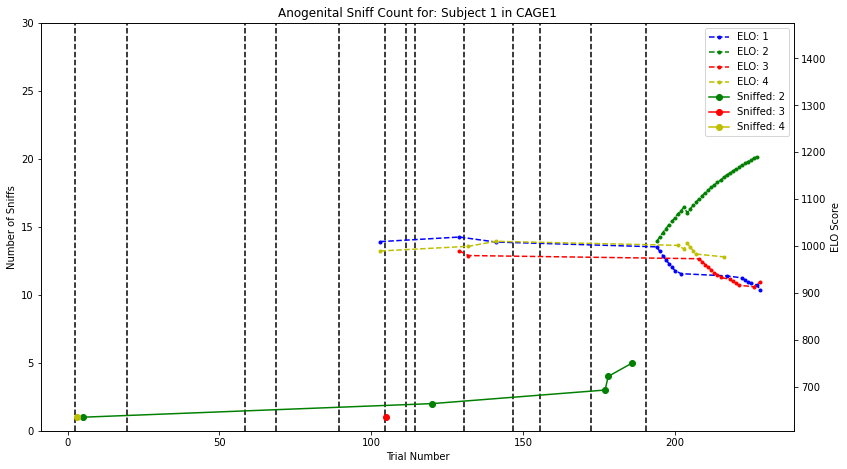

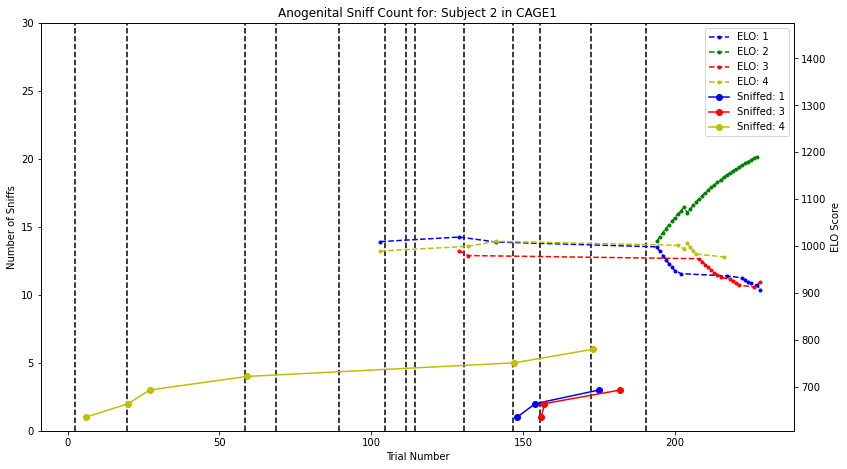

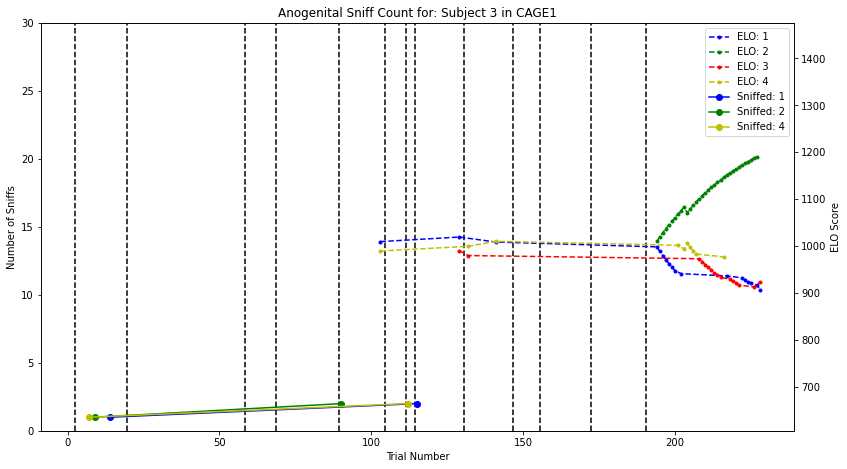

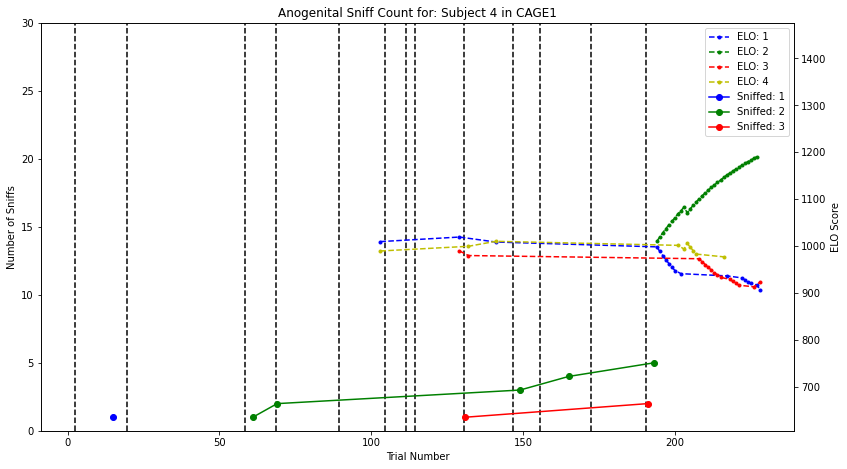

CAGE2


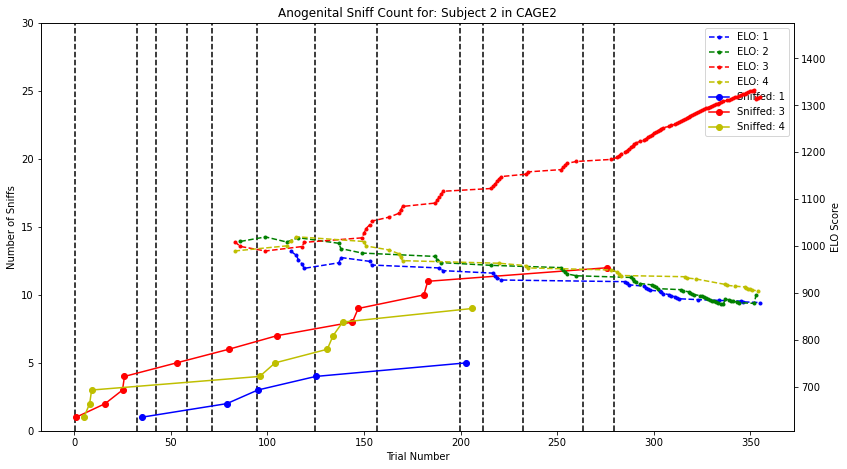

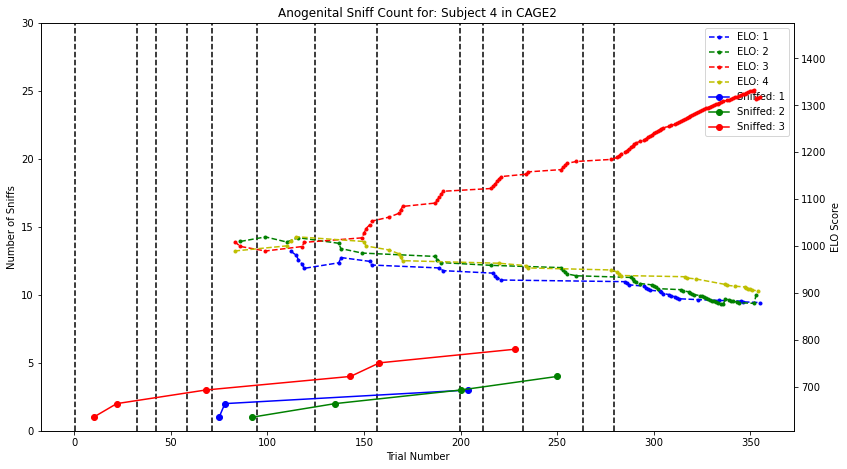

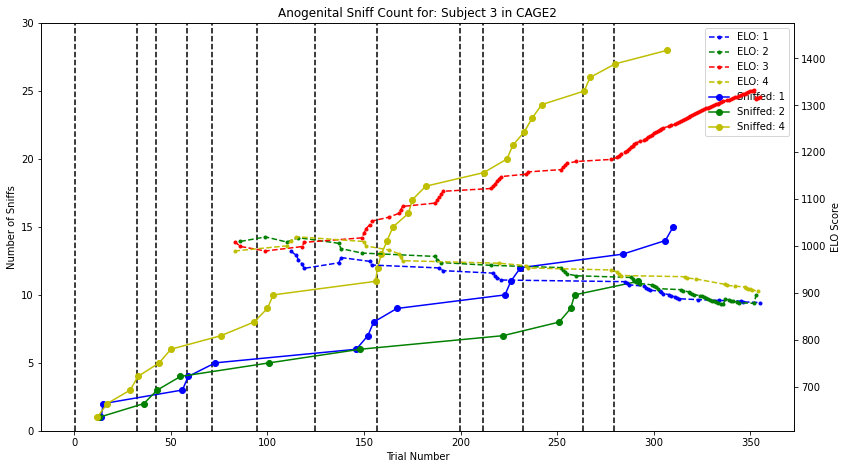

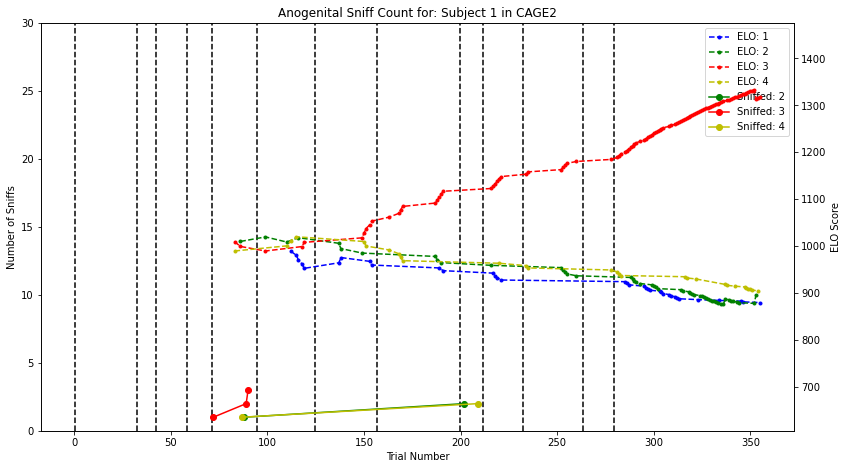

CAGE3


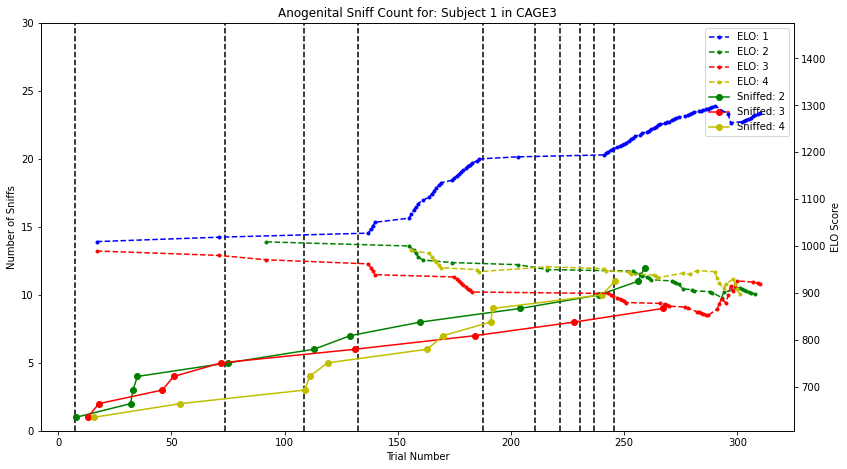

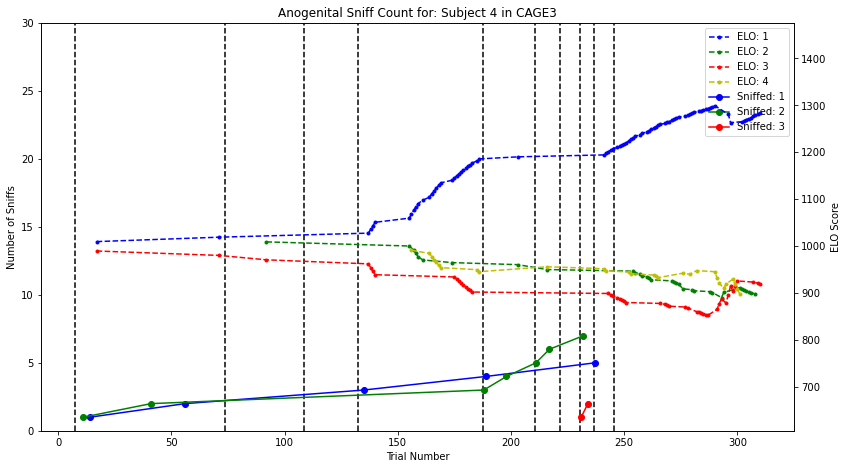

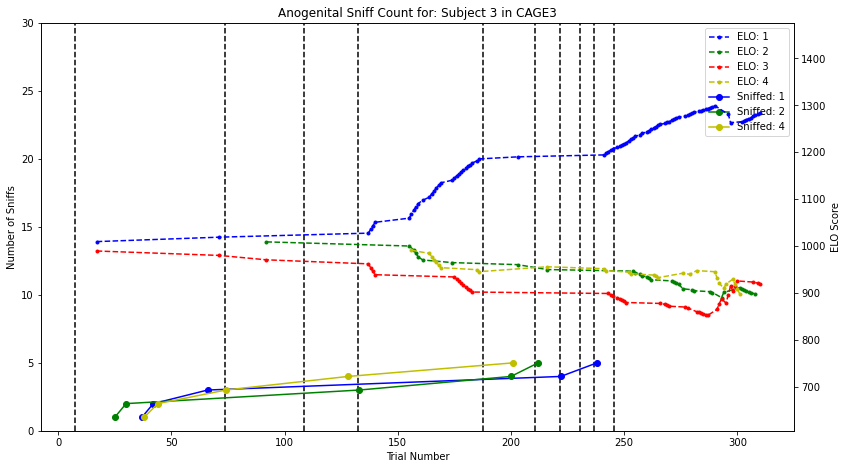

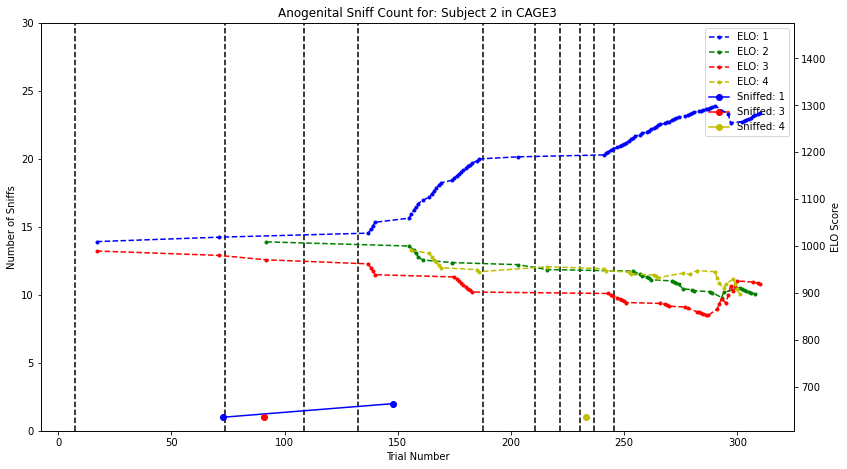

CAGE4


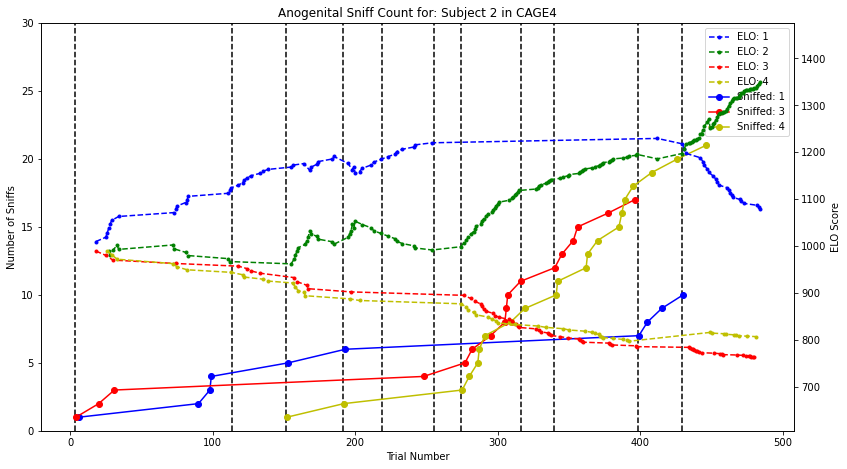

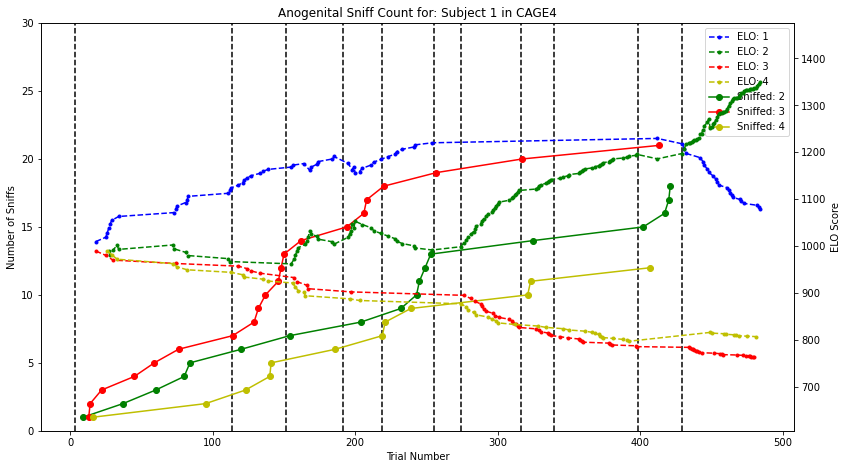

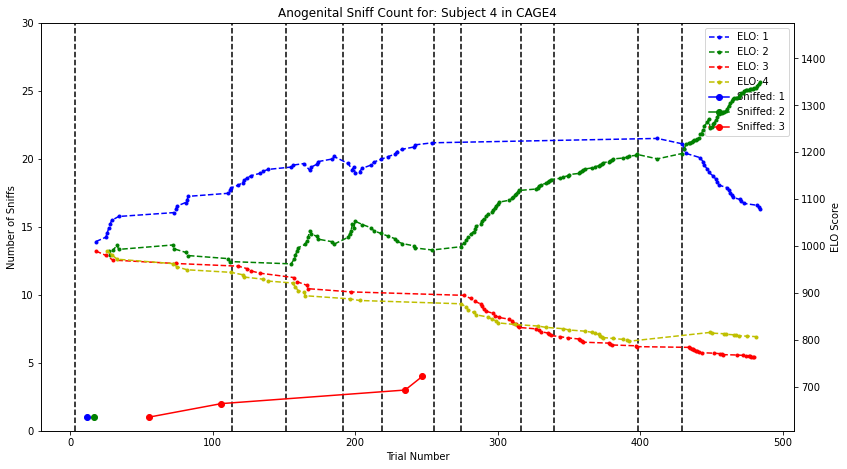

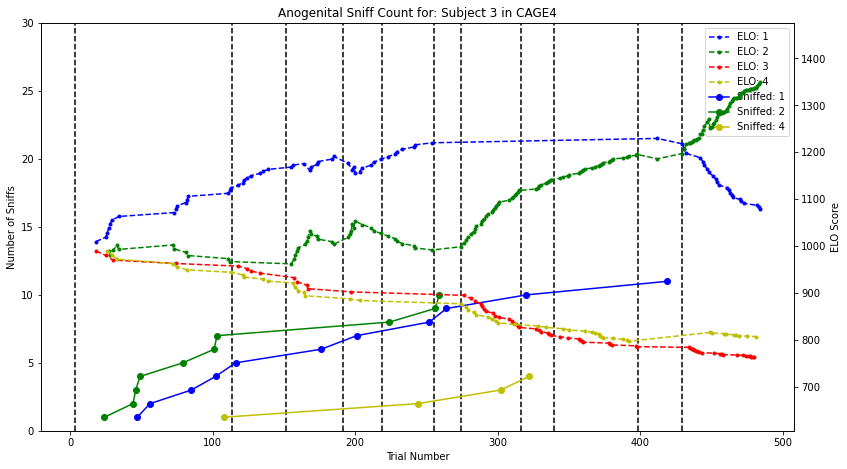

CAGE5


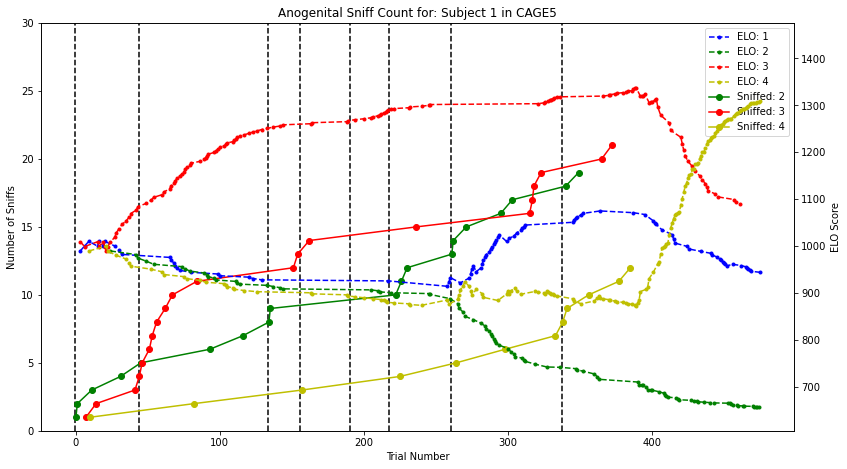

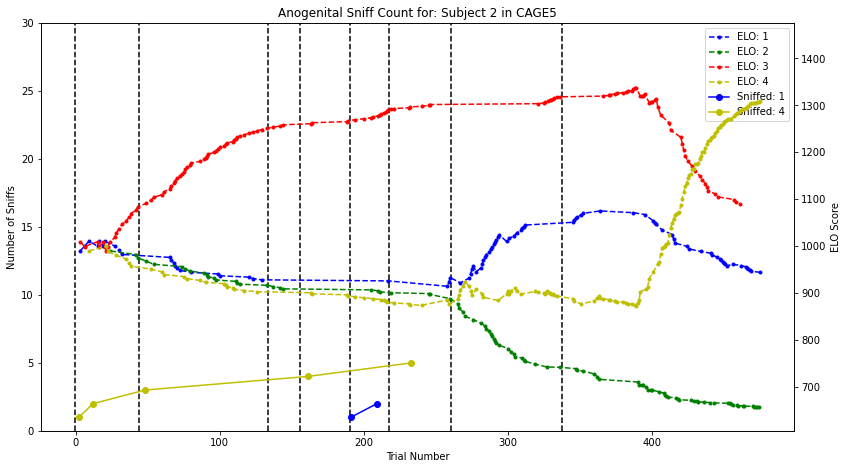

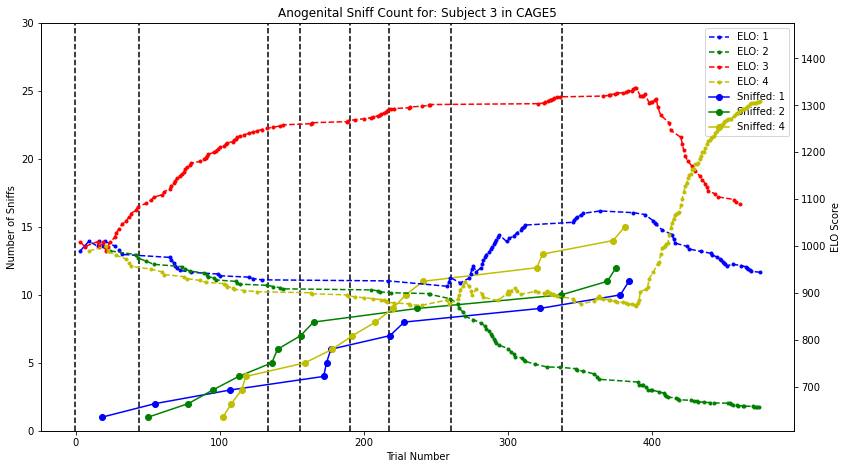

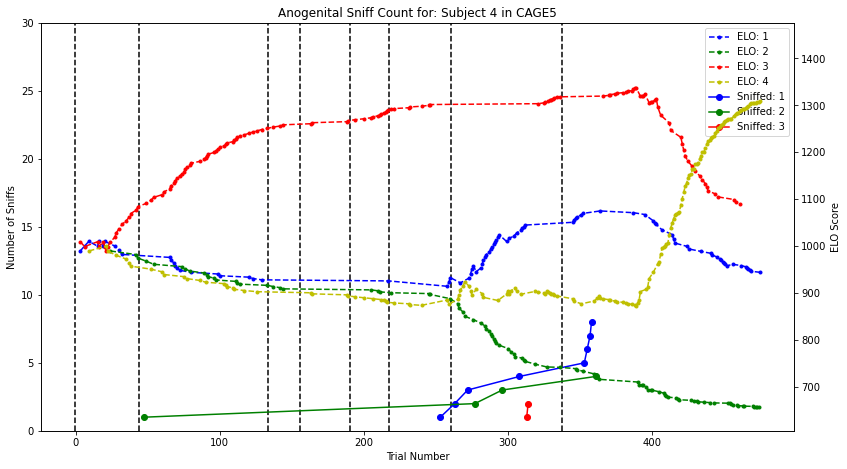

CAGE6


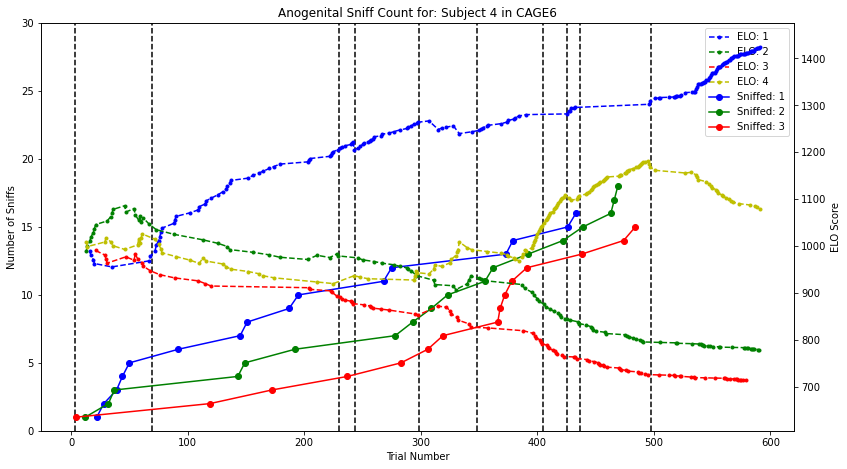

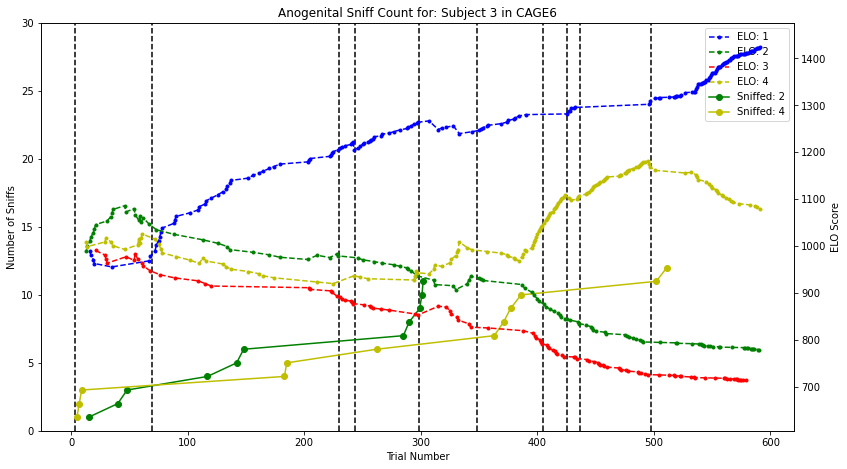

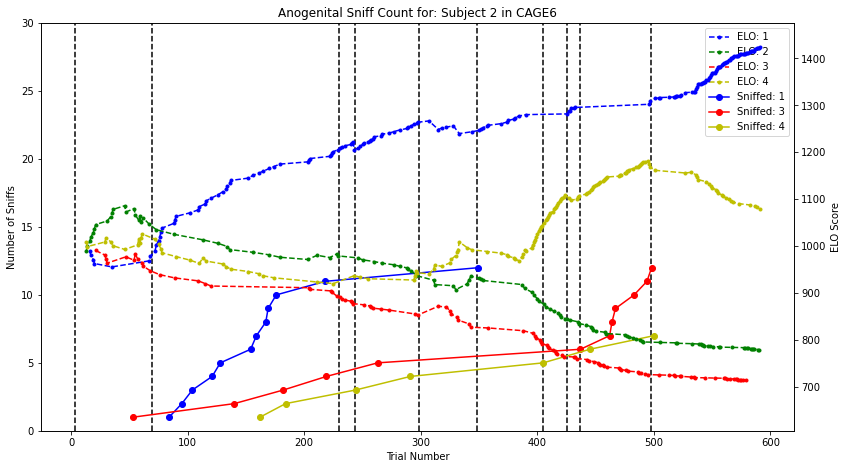

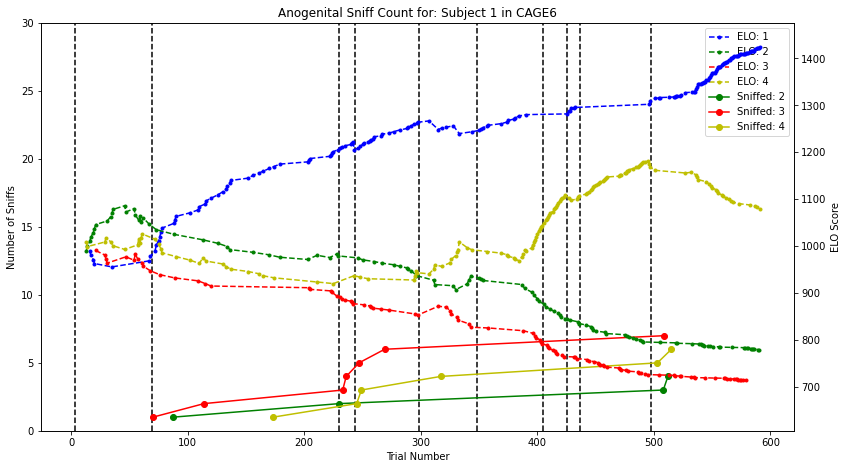

In [161]:
colors = ["b", "g", "r", "y"]
# Making a plot for each sheet
for key, value in sheet_name_to_everything.items():
    plt.rcParams["figure.figsize"] = (13.5,7.5)
    print(key)
    elo_score_dataframe = value["elo_score_dataframe"]
    sniff_dataframe = value["anogenital_sniff_dataframe"]
       
    # Drawing a line for each subject
    #     for subject in sorted(sniff_dataframe["subject_id"].unique()):
    for winner in sniff_dataframe[sheet_name_to_everything[key]["winner_column"]].unique():
        fig, sniff_plot = plt.subplots()        
        sniff_plot.set_title("Anogenital Sniff Count for: Subject {} in {}".format(winner, key))



        
        labels = []
        # More versatile wrapper
#         fig, sniff_plot = plt.subplots(figsize=(8,5)) # (width, height) in inches
        # (see https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplots.html)

        elo_score_plot = sniff_plot.twinx()

#         sniff_plot.set_xlim(0, 2)
        sniff_plot.set_ylim(0, 30)
        elo_score_plot.set_ylim(min_elo_score-50, max_elo_score+50) 


        sniff_plot.set_xlabel("Trial Number")
        sniff_plot.set_ylabel("Number of Sniffs")
        elo_score_plot.set_ylabel("ELO Score")
        
        
        # Drawing vertical lines that represent when each session begins
        # Based on when a row has a different session than the previous row
        for index, row in sniff_dataframe[sniff_dataframe['session_number_difference'] != 0.0].iterrows():
            # Offsetting by 0.5 to avoid drawing the line on the dot
#             plt.vlines(x=[row["all_trial_number"] - 0.5], ymin=0, ymax=15, colors='black', linestyle='dashed')
            sniff_plot.vlines(x=[row["all_trial_number"] - 0.5], ymin=0, ymax=30, colors='black', linestyle='dashed')

        # Drawing a line for each subject
        for subject in sorted(elo_score_dataframe["subject_id"].unique()):
            # Getting all the rows with the current subject
            subject_dataframe = elo_score_dataframe[elo_score_dataframe["subject_id"] == subject]
            # Making the current match number the X-Axis
            p1, = elo_score_plot.plot(subject_dataframe["all_trial_number"], subject_dataframe["updated_elo_score"], '--.', label="ELO: {}".format(subject), color=colors[subject-1])
            labels.append(p1)
        # Getting all the rows with the current subject
        subject_dataframe = sniff_dataframe[sniff_dataframe[sheet_name_to_everything[key]["winner_column"]] == winner]
        for loser in sorted(subject_dataframe[sheet_name_to_everything[key]["loser_column"]].unique()):
            loser_dataframe = subject_dataframe[subject_dataframe[sheet_name_to_everything[key]["loser_column"]] == loser]
            
            # Making the current match number the X-Axis
            p1, = sniff_plot.plot(loser_dataframe["all_trial_number"], loser_dataframe["sniff_count"], '-o', label="Sniffed: {}".format(loser), color=colors[loser-1])
            labels.append(p1)
            

        # Showing the plots
        sniff_plot.legend(handles=labels, loc='best')
        
        # Saving the plot
        file_name = "anogenital_cage_{}_subject_{}_date_{}_{}.png".format(protocol_name, key, winner, earliest_date, latest_date)
        plt.savefig(os.path.join(plot_output_directory, file_name))
        plt.show()
        

- Creating an output directory to save the plots

In [ ]:
protocol_name = "facial_sniffing_count"

In [ ]:
plot_output_directory = "./proc/plots/{}/cage_{}_date_{}_{}".format(protocol_name, all_cages_string, earliest_date, latest_date)

In [ ]:
plot_output_directory

In [ ]:
os.makedirs(plot_output_directory, exist_ok=True)

In [ ]:
colors = ["b", "g", "r", "y"]
# Making a plot for each sheet
for key, value in sheet_name_to_everything.items():
    plt.rcParams["figure.figsize"] = (13.5,7.5)
    print(key)
    elo_score_dataframe = value["elo_score_dataframe"]
    sniff_dataframe = value["facial_sniff_dataframe"]
       
    # Drawing a line for each subject
    #     for subject in sorted(sniff_dataframe["subject_id"].unique()):
    for winner in sniff_dataframe[sheet_name_to_everything[key]["winner_column"]].unique():
        fig, sniff_plot = plt.subplots()        
        sniff_plot.set_title("Facial Sniff Count for: Subject {} in {}".format(winner, key))
        
        labels = []
        # More versatile wrapper
#         fig, sniff_plot = plt.subplots(figsize=(8,5)) # (width, height) in inches
        # (see https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplots.html)

        elo_score_plot = sniff_plot.twinx()

#         sniff_plot.set_xlim(0, 2)
        sniff_plot.set_ylim(0, 45)
        elo_score_plot.set_ylim(min_elo_score-50, max_elo_score+50) 


        sniff_plot.set_xlabel("Trial Number")
        sniff_plot.set_ylabel("Number of Sniffs")
        elo_score_plot.set_ylabel("ELO Score")
        
        
        # Drawing vertical lines that represent when each session begins
        # Based on when a row has a different session than the previous row
        for index, row in sniff_dataframe[sniff_dataframe['session_number_difference'] != 0.0].iterrows():
            # Offsetting by 0.5 to avoid drawing the line on the dot
#             plt.vlines(x=[row["all_trial_number"] - 0.5], ymin=0, ymax=15, colors='black', linestyle='dashed')
            sniff_plot.vlines(x=[row["all_trial_number"] - 0.5], ymin=0, ymax=45, colors='black', linestyle='dashed')

        # Drawing a line for each subject
        for subject in sorted(elo_score_dataframe["subject_id"].unique()):
            # Getting all the rows with the current subject
            subject_dataframe = elo_score_dataframe[elo_score_dataframe["subject_id"] == subject]
            # Making the current match number the X-Axis
            p1, = elo_score_plot.plot(subject_dataframe["all_trial_number"], subject_dataframe["updated_elo_score"], '--.', label="ELO: {}".format(subject), color=colors[subject-1])
            labels.append(p1)
        # Getting all the rows with the current subject
        subject_dataframe = sniff_dataframe[sniff_dataframe[sheet_name_to_everything[key]["winner_column"]] == winner]
        for loser in sorted(subject_dataframe[sheet_name_to_everything[key]["loser_column"]].unique()):
            loser_dataframe = subject_dataframe[subject_dataframe[sheet_name_to_everything[key]["loser_column"]] == loser]
            
            # Making the current match number the X-Axis
            p1, = sniff_plot.plot(loser_dataframe["all_trial_number"], loser_dataframe["sniff_count"], '-o', label="Sniffed: {}".format(loser), color=colors[loser-1])
            labels.append(p1)
            

        # Showing the plots
        sniff_plot.legend(handles=labels, loc='best')
        
        # Saving the plot
        file_name = "facial_elo_score_cage_{}_subject_{}_date_{}_{}.png".format(protocol_name, key, winner, earliest_date, latest_date)
        plt.savefig(os.path.join(plot_output_directory, file_name))
        plt.show()
        

In [ ]:
raise ValueError()

# TODO: Drawing plots with the ranking of the agent ID

In [ ]:
subject_dataframe

In [ ]:
elo_score_dataframe

In [ ]:
colors = ["b", "g", "r", "y"]
# Making a plot for each sheet
for key, value in sheet_name_to_everything.items():
    plt.rcParams["figure.figsize"] = (13.5,7.5)
    print(key)
    elo_score_dataframe = value["elo_score_dataframe"]
    sniff_dataframe = value["facial_sniff_dataframe"]
       
    # Drawing a line for each subject
    #     for subject in sorted(sniff_dataframe["subject_id"].unique()):
    for winner in sniff_dataframe[sheet_name_to_everything[key]["winner_column"]].unique():
        fig, sniff_plot = plt.subplots()        
        sniff_plot.set_title("Facial Sniff Count for: Subject {} in {}".format(winner, key))
        
        labels = []
        # More versatile wrapper
#         fig, sniff_plot = plt.subplots(figsize=(8,5)) # (width, height) in inches
        # (see https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplots.html)

        elo_score_plot = sniff_plot.twinx()

#         sniff_plot.set_xlim(0, 2)
        sniff_plot.set_ylim(0, 45)
        elo_score_plot.set_ylim(min_elo_score-50, max_elo_score+50) 


        sniff_plot.set_xlabel("Trial Number")
        sniff_plot.set_ylabel("Number of Sniffs")
        elo_score_plot.set_ylabel("ELO Score")
        
        
        # Drawing vertical lines that represent when each session begins
        # Based on when a row has a different session than the previous row
        for index, row in sniff_dataframe[sniff_dataframe['session_number_difference'] != 0.0].iterrows():
            # Offsetting by 0.5 to avoid drawing the line on the dot
#             plt.vlines(x=[row["all_trial_number"] - 0.5], ymin=0, ymax=15, colors='black', linestyle='dashed')
            sniff_plot.vlines(x=[row["all_trial_number"] - 0.5], ymin=0, ymax=45, colors='black', linestyle='dashed')

        # Drawing a line for each subject
        for subject in sorted(elo_score_dataframe["subject_id"].unique()):
            # Getting all the rows with the current subject
            subject_dataframe = elo_score_dataframe[elo_score_dataframe["subject_id"] == subject]
            # Making the current match number the X-Axis
            p1, = elo_score_plot.plot(subject_dataframe["all_trial_number"], subject_dataframe["updated_elo_score"], '--.', label="ELO: {}".format(subject), color=colors[subject-1])
            labels.append(p1)
        # Getting all the rows with the current subject
        subject_dataframe = sniff_dataframe[sniff_dataframe[sheet_name_to_everything[key]["winner_column"]] == winner]
        for loser in sorted(subject_dataframe[sheet_name_to_everything[key]["loser_column"]].unique()):
            loser_dataframe = subject_dataframe[subject_dataframe[sheet_name_to_everything[key]["loser_column"]] == loser]
            
            # Making the current match number the X-Axis
            p1, = sniff_plot.plot(loser_dataframe["all_trial_number"], loser_dataframe["sniff_count"], '-o', label="Sniffed: {}".format(loser), color=colors[loser-1])
            labels.append(p1)
            

        # Showing the plots
        sniff_plot.legend(handles=labels, loc='best')
        
        # Saving the plot
        file_name = "facial_elo_score_cage_{}_subject_{}_date_{}_{}.png".format(protocol_name, key, winner, earliest_date, latest_date)
        plt.savefig(os.path.join(plot_output_directory, file_name))
        plt.show()

In [ ]:
colors = ["b", "g", "r", "y"]
# Making a plot for each sheet
for key, value in sheet_name_to_everything.items():
    plt.rcParams["figure.figsize"] = (13.5,7.5)
    print(key)
    elo_score_dataframe = value["elo_score_dataframe"]
    sniff_dataframe = value["facial_sniff_dataframe"]
       
    # Drawing a line for each subject
    #     for subject in sorted(sniff_dataframe["subject_id"].unique()):
    for winner in sniff_dataframe[sheet_name_to_everything[key]["winner_column"]].unique():
        fig, sniff_plot = plt.subplots()        
        sniff_plot.set_title("Facial Sniff Count for: Subject {} in {}".format(winner, key))
        
        labels = []
        # More versatile wrapper
#         fig, sniff_plot = plt.subplots(figsize=(8,5)) # (width, height) in inches
        # (see https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplots.html)

        elo_score_plot = sniff_plot.twinx()

#         sniff_plot.set_xlim(0, 2)
        sniff_plot.set_ylim(0, 45)
        elo_score_plot.set_ylim(min_elo_score-50, max_elo_score+50) 


        sniff_plot.set_xlabel("Trial Number")
        sniff_plot.set_ylabel("Number of Sniffs")
        elo_score_plot.set_ylabel("ELO Score")
        
        
        # Drawing vertical lines that represent when each session begins
        # Based on when a row has a different session than the previous row
        for index, row in sniff_dataframe[sniff_dataframe['session_number_difference'] != 0.0].iterrows():
            # Offsetting by 0.5 to avoid drawing the line on the dot
#             plt.vlines(x=[row["all_trial_number"] - 0.5], ymin=0, ymax=15, colors='black', linestyle='dashed')
            sniff_plot.vlines(x=[row["all_trial_number"] - 0.5], ymin=0, ymax=45, colors='black', linestyle='dashed')

        # Drawing a line for each subject
        for subject in sorted(elo_score_dataframe["subject_id"].unique()):
            # Getting all the rows with the current subject
            subject_dataframe = elo_score_dataframe[elo_score_dataframe["subject_id"] == subject]
            # Making the current match number the X-Axis
            p1, = elo_score_plot.plot(subject_dataframe["all_trial_number"], subject_dataframe["updated_elo_score"], '--.', label="ELO: {}".format(subject), color=colors[subject-1])
            labels.append(p1)
        # Getting all the rows with the current subject
        subject_dataframe = sniff_dataframe[sniff_dataframe[sheet_name_to_everything[key]["winner_column"]] == winner]
        for loser in sorted(subject_dataframe[sheet_name_to_everything[key]["loser_column"]].unique()):
            loser_dataframe = subject_dataframe[subject_dataframe[sheet_name_to_everything[key]["loser_column"]] == loser]
            
            # Making the current match number the X-Axis
            p1, = sniff_plot.plot(loser_dataframe["all_trial_number"], loser_dataframe["sniff_count"], '-o', label="Sniffed: {}".format(loser), color=colors[loser-1])
            labels.append(p1)
            

        # Showing the plots
        sniff_plot.legend(handles=labels, loc='best')
        
        # Saving the plot
        file_name = "facial_elo_score_cage_{}_subject_{}_date_{}_{}.png".format(protocol_name, key, winner, earliest_date, latest_date)
#         plt.savefig(os.path.join(plot_output_directory, file_name))
        plt.show()

In [ ]:
colors = ["b", "g", "r", "y"]
# Making a plot for each sheet
for key, value in sheet_name_to_everything.items():
    plt.rcParams["figure.figsize"] = (13.5,7.5)
    print(key)
    elo_score_dataframe = value["elo_score_dataframe"]
    sniff_dataframe = value["facial_sniff_dataframe"]
       
    # Drawing a line for each subject
    #     for subject in sorted(sniff_dataframe["subject_id"].unique()):
    for winner in sniff_dataframe[sheet_name_to_everything[key]["winner_column"]].unique():
        fig, sniff_plot = plt.subplots()        
        sniff_plot.set_title("Facial Sniff Count for: Subject {} in {}".format(winner, key))
        
        labels = []
        # More versatile wrapper
#         fig, sniff_plot = plt.subplots(figsize=(8,5)) # (width, height) in inches
        # (see https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplots.html)

        elo_score_plot = sniff_plot.twinx()

#         sniff_plot.set_xlim(0, 2)
        sniff_plot.set_ylim(0, 45)
        elo_score_plot.set_ylim(min_elo_score-50, max_elo_score+50) 


        sniff_plot.set_xlabel("Trial Number")
        sniff_plot.set_ylabel("Number of Sniffs")
        elo_score_plot.set_ylabel("ELO Score")
        
        
        # Drawing vertical lines that represent when each session begins
        # Based on when a row has a different session than the previous row
        for index, row in sniff_dataframe[sniff_dataframe['session_number_difference'] != 0.0].iterrows():
            # Offsetting by 0.5 to avoid drawing the line on the dot
#             plt.vlines(x=[row["all_trial_number"] - 0.5], ymin=0, ymax=15, colors='black', linestyle='dashed')
            sniff_plot.vlines(x=[row["all_trial_number"] - 0.5], ymin=0, ymax=45, colors='black', linestyle='dashed')

        # Drawing a line for each subject
        for subject in sorted(elo_score_dataframe["subject_id"].unique()):
            # Getting all the rows with the current subject
            subject_dataframe = elo_score_dataframe[elo_score_dataframe["subject_id"] == subject]
            # Making the current match number the X-Axis
            p1, = elo_score_plot.plot(subject_dataframe["all_trial_number"], subject_dataframe["updated_elo_score"], '--.', label="ELO: {}".format(subject), color=colors[subject-1])
            labels.append(p1)
        # Getting all the rows with the current subject
        subject_dataframe = sniff_dataframe[sniff_dataframe[sheet_name_to_everything[key]["winner_column"]] == winner]
        for loser in sorted(subject_dataframe[sheet_name_to_everything[key]["loser_column"]].unique()):
            loser_dataframe = subject_dataframe[subject_dataframe[sheet_name_to_everything[key]["loser_column"]] == loser]
            
            # Making the current match number the X-Axis
            p1, = sniff_plot.plot(loser_dataframe["all_trial_number"], loser_dataframe["sniff_count"], '-o', label="Sniffed: {}".format(loser), color=colors[loser-1])
            labels.append(p1)
            

        # Showing the plots
        sniff_plot.legend(handles=labels, loc='best')
        
        # Saving the plot
        file_name = "facial_elo_score_cage_{}_subject_{}_date_{}_{}.png".format(protocol_name, key, winner, earliest_date, latest_date)
#         plt.savefig(os.path.join(plot_output_directory, file_name))
        plt.show()

# Saving the Dataframes

In [ ]:
elo_score_spreadsheet_output_directory = "./proc/elo_score_spread_sheets/{}_elo_score/cage_{}_date_{}_{}".format(protocol_name, all_cages_string, earliest_date, latest_date)

In [ ]:
elo_score_spreadsheet_output_directory

In [ ]:
os.makedirs(elo_score_spreadsheet_output_directory, exist_ok=True)

In [ ]:
file_name = "{}_elo_score_history_cages_{}_date_{}_{}.csv".format(protocol_name, all_cages_string, earliest_date, latest_date)
all_sheet_elo_scord_dataframe_combined.to_csv(os.path.join(elo_score_spreadsheet_output_directory, file_name))

In [ ]:
file_name = "{}_final_elo_score_cages_{}_date_{}_{}.csv".format(protocol_name, all_cages_string, earliest_date, latest_date)
id_to_final_elo_score_dataframe.to_csv(os.path.join(elo_score_spreadsheet_output_directory, file_name))